# Telegram Analysis

## Prepare environment

In [1]:
"""
Set flag to true, if you work in visual studio code (connected to custom docker)
Set flag to false, if you work in browser (jupyter notebook ui from custom docker)
"""
FLAG_LOCAL              = True

"""
Set flag to true, if you want process no long term running tasks
"""
FLAG_SHORT_RUN          = False

"""
Load DataSets
Ava:    ["dataSet0", "dataSet1", "dataSet1a"]
Req:    ["dataSet0]
"""
C_LOAD_DATASET          = ["dataSet0", "dataSet1a"]

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Import url libs
from urllib.parse import urlparse
from collections import Counter
import requests

# File Handler Lib
from pathlib import Path

# Set graph widget (used by jupyter notebook)
#%matplotlib notebook   #interactive graphs
%matplotlib inline

In [3]:
# Install and import Graph Lib
import networkx as nx
#! pip install pydot

In [4]:
# Install and import  JSON Lib
#! pip install demjson
import demjson

In [5]:
# Install and import Natural Language Toolkit
#! pip install nltk
import nltk

# Ngrams
import re
from nltk.util import ngrams

# Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Gensim and pyLDAvis
#! pip install gensim
#! pip install pyLDAvis

import gensim

from gensim.utils import simple_preprocess

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

import os

# TODO Set to ignore?
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("once")

In [7]:
# Install and import demoji
# Dont exists on conda
import sys
!{sys.executable} -m pip install demoji

import demoji
demoji.download_codes()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... OK (Got response in 0.46 seconds)
Writing emoji data to /home/jovyan/.demoji/codes.json ...
... OK


In [8]:
# Install and import WordCloud
#! pip install wordcloud
from wordcloud import WordCloud

/opt/conda/lib/python3.8/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/opt/conda/lib/python3.8/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [9]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

In [10]:
# Set env vars
if(FLAG_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

dir_var_cache= dir_var + "cache/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

! echo
! echo "- Cachedir -"
! ls -al $dir_var_cache

- Workdir -
total 6608
drwxr-xr-x 10 jovyan users     320 Jan 12 13:54 .
drwxr-xr-x 10 root   root      320 Jan  7 07:47 ..
-rw-r--r--  1 jovyan users      46 Jan 12 12:10 additionalStopwords.txt
drwxr-xr-x  8 jovyan users     256 Jan 12 12:10 cache
drwxr-xr-x  7 jovyan users     224 Jan  5 14:15 data
-rw-r--r--  1 jovyan users    6148 Dec 22 16:15 .DS_Store
-rw-r--r--  1 jovyan users   11400 Jan 10 13:53 inputFiles.csv
drwxr-xr-x  3 jovyan users      96 Dec 20 10:30 .ipynb_checkpoints
drwxr-xr-x  6 jovyan users     192 Jan 12 14:35 output
-rwxr-xr-x  1 jovyan users 6740565 Jan 12 14:36 Telegram.ipynb

- Outputdir -
total 8
drwxr-xr-x  6 jovyan users  192 Jan 12 14:35 .
drwxr-xr-x 10 jovyan users  320 Jan 12 13:54 ..
drwxr-xr-x  3 jovyan users   96 Jan 12 14:35 autoWordCloud
-rw-r--r--  1 jovyan users 6148 Jan  7 08:06 .DS_Store
-rw-r--r--  1 jovyan users    0 Dec 30 10:38 .gitkeep
drwxr-xr-x  3 jovyan users   96 Jan 12 14:35 pyLDAvis

- Cachedir -
total 152
drwxr-xr-x  8 jovyan users 

### Global functions

In [11]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [12]:
"""
Check if text is json formatted

param   text        InputText
param   singleMode  Boolean (set to true, if text is part of a message)
"""
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

In [13]:
def gloReplaceGermanChars(inputText):

    inputText = inputText.replace("ö", "oe")
    inputText = inputText.replace("ü", "ue")
    inputText = inputText.replace("ä", "ae")

    inputText = inputText.replace("Ö", "Oe")
    inputText = inputText.replace("Ü", "Ue")
    inputText = inputText.replace("Ä", "Ae")

    inputText = inputText.replace("ß", "ss")
    
    return inputText

In [14]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = demoji.replace(text, "")
    text = gloReplaceGermanChars(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    #text = text.encode('ascii', 'ignore')
    #text = text.decode('ascii')
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

In [15]:
# Write dict to file (CSV)
def gloWriteDictToFile(filename, targetDict):
    d = pd.DataFrame.from_dict(targetDict, orient="index")
    d.to_csv(dir_var_cache + filename, header=False)

# Read dict from file (CSV)
def gloReadDictFromFile(filename):
    d = pd.read_csv(dir_var_cache + filename, header=None, index_col=0, squeeze=True)
    return d.to_dict()

# Init csv file if not exists
def gloInitFileDict(filename):
    f = Path(dir_var_cache + filename)
    if(f.exists() == False):
        print("Init cache file >>" + filename + "<<")
        f.touch()
        gloWriteDictToFile(filename, {"initKey": "initValue"})
    else:
        print("Cache already exists >>" + filename + "<<")

In [16]:
# Check if is already cached
def gloCheckIsAlreadyCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    if(targetKey in targetDict.keys()):
        return True
    else:
        return False

# Add key to cache
def gloAddToCache(filename, targetKey, targetValue):
    targetDict = gloReadDictFromFile(filename)
    targetDict[targetKey] = targetValue
    gloWriteDictToFile(filename, targetDict)

# Get key from cache
def gloGetCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    return targetDict[targetKey]

#### Init Cache Files

In [17]:
gloInitFileDict("resolved-urls.csv")

Cache already exists >>resolved-urls.csv<<


## Process input jobs

In [18]:
gloStartStopwatch("Global notebook")

[Stopwatch started >>Global notebook<<]


In [19]:
# Read jobs from file
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

In [20]:
dfFilter = pd.DataFrame()

for dS in C_LOAD_DATASET:
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputDesc == dS])

dfInputFiles = dfFilter

### Overview input jobs

In [21]:
dfInputFiles

inputName  \
47                 ATTILA HILDMANN   
48       Oliver Janich oeffentlich   
49            Eva Herman Offiziell   
50     Xavier Naidoo (inoffiziell)   
58                  FREIHEITS-CHAT   
60           FREIHEITSCHAT - BLITZ   
98  Livestreaming fuer Deutschland   

                                            inputPath          inputType  \
47       DS-05-01-2021/ChatExport_2021-01-05-hildmann     public_channel   
48         DS-05-01-2021/ChatExport_2021-01-05-janich     public_channel   
49      DS-05-01-2021/ChatExport_2021-01-05-evaherman     public_channel   
50         DS-05-01-2021/ChatExport_2021-01-05-xavier     public_channel   
58  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...  public_supergroup   
60  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...  public_supergroup   
98  DS-05-01-2021a/ChatExport_2021-01-05-liveFuerD...  public_supergroup   

        inputId  inputDesc inputDownloadType  
47  10034163583   dataSet0          onlyText  
48   9808932799   dataSet0          onlyText  
49   9915108907   dataSet0          onlyText  
50   9874390332   dataSet0          onlyText  
58   9717909816  dataSet1a          onlyText  
60   9943834900  dataSet1a          onlyText  
98   9943535763  dataSet1a          onlyText

### Transform data into DataFrmaes

In [22]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):
    a,b,c,d,e,f,g = extractedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(key)

In [24]:
# TODO: href, mention and hashtags in normal text?

"""
Extract text data (see cell above key)
See cell above (key)

param   procIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(procIsJsonFormatted, text):
    
    # 3 returns in this function...
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(procIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        #returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + str(subJsonType) + "<< (ignore) >>" + str(text) + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + str(text) + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [25]:
def evalIsValidText(procTDTextLength):
    if(procTDTextLength > 0):
        return True
    else:
        return False

In [26]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [27]:
def evalNonEmptyList(att):
    if(str(att) == "[]"):
        return False
    else:
        return True

In [28]:
gloStartStopwatch("Extract Text Data")

# Add Key = filePath / Value = DataFrame (Chat Meta)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Chat Message)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    gloStartStopwatch("TD-Extract " + fP)
    dfMessages                          = convertToDataFrameMessages(fP)
    
    # Get chat attributes and check if message is json formatted
    dfMessages["procChatFilePath"]      = fP
    dfMessages["procChatType"]          = dictMeta[fP].type.iloc[0]
    dfMessages["procIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)
    
    # Extract Text Data
    dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.procIsJsonFormatted, x.text), axis=1)

    # Extract Text Data (params)
    dfMessages["procTDText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)
    dfMessages["procTDURLs"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)
    dfMessages["procTDHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
    dfMessages["procTDBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
    dfMessages["procTDItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
    dfMessages["procTDUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)
    dfMessages["procTDEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)

    # Process text again
    dfMessages['procTDCleanText']           = dfMessages['procTDText'].map(lambda x: re.sub('\n', ' ', x)) # Replace \n
    dfMessages['procTDEmojis']              = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = False)) # Filter out emoji
    dfMessages['procTDEmojisDesc']          = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = True)) # Filter out emoji with desc
    dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: demoji.replace(x, " ")) # Rm emoji
    dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: gloReplaceGermanChars(x)) # Replace german chars
    dfMessages['procTDSafeText']            = dfMessages['procTDCleanText'].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x)) # Filter out . ! ? ... (get only safe chars)
    dfMessages['procTDSafeLowercaseText']   = dfMessages['procTDSafeText'].map(lambda x: x.lower()) # To lower

    # Calc text size
    dfMessages["procTDTextLength"]      = dfMessages["procTDCleanText"].str.len()

    # Add columns (if not exists)
    if "photo" not in dfMessages:
        print("- Debug: Add column >>photo<<")
        dfMessages["photo"] = np.nan

    if "file" not in dfMessages:
        print("- Debug: Add column >>file<<")
        dfMessages["file"] = np.nan

    if "edited" not in dfMessages:
        print("- Debug: Add column >>edited<<")
        dfMessages["edited"] = np.nan

    if "forwarded_from" not in dfMessages:
        print("- Debug: Add column >>forwarded_from<<")
        dfMessages["forwarded_from"] = np.nan

    # Evaluate attributes
    dfMessages["procEvalIsValidText"]   = dfMessages.procTDTextLength.apply(evalIsValidText)

    dfMessages["procEvalContainsPhoto"] = dfMessages.photo.apply(evalContainsSomething)
    dfMessages["procEvalContainsFile"]  = dfMessages.file.apply(evalContainsSomething) 
    dfMessages["procEvalIsEdited"]      = dfMessages.edited.apply(evalContainsSomething)
    dfMessages["procEvalIsForwarded"]   = dfMessages.forwarded_from.apply(evalContainsSomething)
    
    dfMessages["procEvalContainsUrl"]              = dfMessages.procTDURLs.apply(evalNonEmptyList)
    dfMessages["procEvalContainsHashtag"]          = dfMessages.procTDHashtags.apply(evalNonEmptyList)
    dfMessages["procEvalContainsBoldItem"]         = dfMessages.procTDBolds.apply(evalNonEmptyList)
    dfMessages["procEvalContainsItalicItem"]       = dfMessages.procTDItalics.apply(evalNonEmptyList)
    dfMessages["procEvalContainsUnderlineItem"]    = dfMessages.procTDUnderlines.apply(evalNonEmptyList)
    dfMessages["procEvalContainsEmailItem"]        = dfMessages.procTDEmails.apply(evalNonEmptyList)
    dfMessages['procEvalContainsEmojiItem']        = dfMessages.procTDEmojis.apply(evalNonEmptyList)

    # Add to dict    
    dictMessages[fP] = dfMessages
    gloStopStopwatch("TD-Extract " + fP)

# All Messages to DataFrame
gloStartStopwatch("Generate global DataFrame")
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)
gloStopStopwatch("Generate global DataFrame")

gloStopStopwatch("Extract Text Data")

[Stopwatch started >>Extract Text Data<<]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<< (142.298s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<< (351.395s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<< (213.350s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<< (68.413s)]
[Stopwatch started >>TD-Extract DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat<<]
- Warn: Json parser error (set inputText to returnText) >>[Nachweis hier einfügen]<<
- Error: Unkown json type >>cashtag<< (ignore) >>['In Australien, wer sich einem PCR Test widersetzt bekommt B

## Meta-Queries

### Type of channels

In [29]:
dfInputFiles.inputType.value_counts()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


public_channel       4
public_supergroup    3
Name: inputType, dtype: int64

### Define queries

In [30]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [31]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [32]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [33]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [34]:
def queryNumberOfMessagesByAttEqTrue(filePath, attKey):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages[attKey] == True]
    return len(dfMessages.index)

### Execute queries

In [35]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)

dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procIsJsonFormatted"), axis=1)

dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsValidText"), axis=1)

dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsPhoto"), axis=1)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsFile"), axis=1)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsEdited"), axis=1)
dfQueryMeta["qryNumberOfForwardedMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsForwarded"), axis=1)

dfQueryMeta["qryNumberOfMessagesWithUrl"]           = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUrl"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithHashtag"]       = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsHashtag"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithBold"]          = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsBoldItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithItalic"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsItalicItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithUnderline"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUnderlineItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmail"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmailItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmoji"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmojiItem"), axis=1)

dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

inputPath    qryChatId  \
58  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...   9717909816   
60  DS-05-01-2021a/ChatExport_2021-01-05-freiheits...   9943834900   
48         DS-05-01-2021/ChatExport_2021-01-05-janich   9808932799   
47       DS-05-01-2021/ChatExport_2021-01-05-hildmann  10034163583   
49      DS-05-01-2021/ChatExport_2021-01-05-evaherman   9915108907   
50         DS-05-01-2021/ChatExport_2021-01-05-xavier   9874390332   
98  DS-05-01-2021a/ChatExport_2021-01-05-liveFuerD...   9943535763   

                       qryChatName        qryChatType  qryNumberOfMessages  \
58                   FREIHEITSCHAT  public_supergroup               377365   
60            FREIHEITSCHAT  BLITZ  public_supergroup               125958   
48       Oliver Janich oeffentlich     public_channel                47026   
47                ATTILA HILDMANN      public_channel                37612   
49            Eva Herman Offiziell     public_channel                36523   
50       Xavier Naidoo inoffiziell     public_channel                12214   
98  Livestreaming fuer Deutschland  public_supergroup                 7092   

    qryNumberOfFormattedTextMessages  qryNumberOfValidTextMessages  \
58                            123812                        235352   
60                             31109                        105907   
48                             32271                         31475   
47                             20128                         23956   
49                             28401                         14105   
50                              7173                          9223   
98                              5259                          6139   

    qryNumberOfPhotos  qryNumberOfFiles  qryNumberOfEditedMessages  \
58              51116             37522                       5091   
60              13878              9815                       2031   
48               7927              6471                       4740   
47              14608              4123                       7359   
49               5509              1978                       2762   
50               4102              1848                       2674   
98                 62                18                        306   

    qryNumberOfForwardedMessages  qryNumberOfMessagesWithUrl  \
58                        106025                       95385   
60                         27838                       19457   
48                         16856                       30941   
47                          9148                       11632   
49                          4949                       27100   
50                          8934                        4224   
98                          2464                        5202   

    qryNumberOfMessagesWithHashtag  qryNumberOfMessagesWithBold  \
58                            5447                        25797   
60                            1241                        10444   
48                            1426                         4004   
47                              66                         8746   
49                             334                         4040   
50                            1929                         1006   
98                             318                          266   

    qryNumberOfMessagesWithItalic  qryNumberOfMessagesWithUnderline  \
58                           6167                              1049   
60                           2929                               130   
48                            968                                65   
47                            209                                17   
49                            930                                12   
50                            173                                68   
98                            118                               161   

    qryNumberOfMessagesWithEmail  qryNumberOfMessagesWithEmoji  
58                           563                    

### Plot meta queries

In [36]:
# Auto label query plot
def autolabelAx(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# param inputDescFilter set "" == no filter
# param outputFilename set "" = no output
def queryMetaPlotter(inputDescFilter, configPlotWidth, configPlotHeight, configBarWidth, outputFilename):
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfForwardedMessages       = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()
    dataNumberOfMessagesWUrl            = list()
    dataNumberOfMessagesWHashtag        = list()
    dataNumberOfMessagesWBold           = list()
    dataNumberOfMessagesWItalic         = list()
    dataNumberOfMessagesWUnderline      = list()
    dataNumberOfMessagesWEmail          = list()
    dataNumberOfMessagesWEmoji          = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes (check filter)
        if(inputDescFilter == "" or dfInputFiles[dfInputFiles.inputPath == row.inputPath].inputDesc.iloc[0] == inputDescFilter):
            dataLabels                          .append(row.qryChatName)
            dataNumberOfMesssages               .append(row.qryNumberOfMessages)
            dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
            dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
            dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
            dataNumberOfForwardedMessages       .append(row.qryNumberOfForwardedMessages)
            dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
            dataNumberOfFiles                   .append(row.qryNumberOfFiles)
            dataNumberOfMessagesWUrl            .append(row.qryNumberOfMessagesWithUrl)
            dataNumberOfMessagesWHashtag        .append(row.qryNumberOfMessagesWithHashtag)
            dataNumberOfMessagesWBold           .append(row.qryNumberOfMessagesWithBold)
            dataNumberOfMessagesWItalic         .append(row.qryNumberOfMessagesWithItalic)
            dataNumberOfMessagesWUnderline      .append(row.qryNumberOfMessagesWithUnderline)
            dataNumberOfMessagesWEmail          .append(row.qryNumberOfMessagesWithEmail)
            dataNumberOfMessagesWEmoji          .append(row.qryNumberOfMessagesWithEmoji)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfForwardedMessages       = np.array(dataNumberOfForwardedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)
    dataNumberOfMessagesWUrl            = np.array(dataNumberOfMessagesWUrl)
    dataNumberOfMessagesWHashtag        = np.array(dataNumberOfMessagesWHashtag)
    dataNumberOfMessagesWBold           = np.array(dataNumberOfMessagesWBold)
    dataNumberOfMessagesWItalic         = np.array(dataNumberOfMessagesWItalic)
    dataNumberOfMessagesWUnderline      = np.array(dataNumberOfMessagesWUnderline)
    dataNumberOfMessagesWEmail          = np.array(dataNumberOfMessagesWEmail)
    dataNumberOfMessagesWEmoji          = np.array(dataNumberOfMessagesWEmoji)

    # Draw
    with sns.color_palette("tab10", 11):
        fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = configBarWidth

    fig.set_figwidth(configPlotWidth)
    fig.set_figheight(configPlotHeight)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]
    r8 = [x + barWidth for x in r7]
    r9 = [x + barWidth for x in r8]
    r10 = [x + barWidth for x in r9]
    r11 = [x + barWidth for x in r10]
    r12 = [x + barWidth for x in r11]
    r13 = [x + barWidth for x in r12]
    r14 = [x + barWidth for x in r13]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Messages')
    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfForwardedMessages, barWidth, label='Forwarded Messages')
    rects6 = ax.bar(r6, dataNumberOfPhotos, barWidth, label='with Photo')
    rects7 = ax.bar(r7, dataNumberOfFiles, barWidth, label='with File')
    rects8 = ax.bar(r8, dataNumberOfMessagesWUrl, barWidth, label='with Url')
    rects9 = ax.bar(r9, dataNumberOfMessagesWHashtag, barWidth, label='with Hashtag')
    rects10 = ax.bar(r10, dataNumberOfMessagesWBold, barWidth, label='with Bold Items')
    rects11 = ax.bar(r11, dataNumberOfMessagesWItalic, barWidth, label='with Italic Items')
    rects12 = ax.bar(r12, dataNumberOfMessagesWUnderline, barWidth, label='with Underlined Items')
    rects13 = ax.bar(r13, dataNumberOfMessagesWEmail, barWidth, label='with E-Mails')
    rects14 = ax.bar(r14, dataNumberOfMessagesWEmoji, barWidth, label='with Emojis')

    chartTitle = ""
    if(inputDescFilter != ""):
        chartTitle = " (" + inputDescFilter + ")"

    ax.set_ylabel("Number of")
    ax.set_title("Meta Overview" + chartTitle)
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6, rects7, rects8, rects9, rects10, rects11, rects12, rects13, rects14]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    #plt.xticks(rotation=30)
    
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()

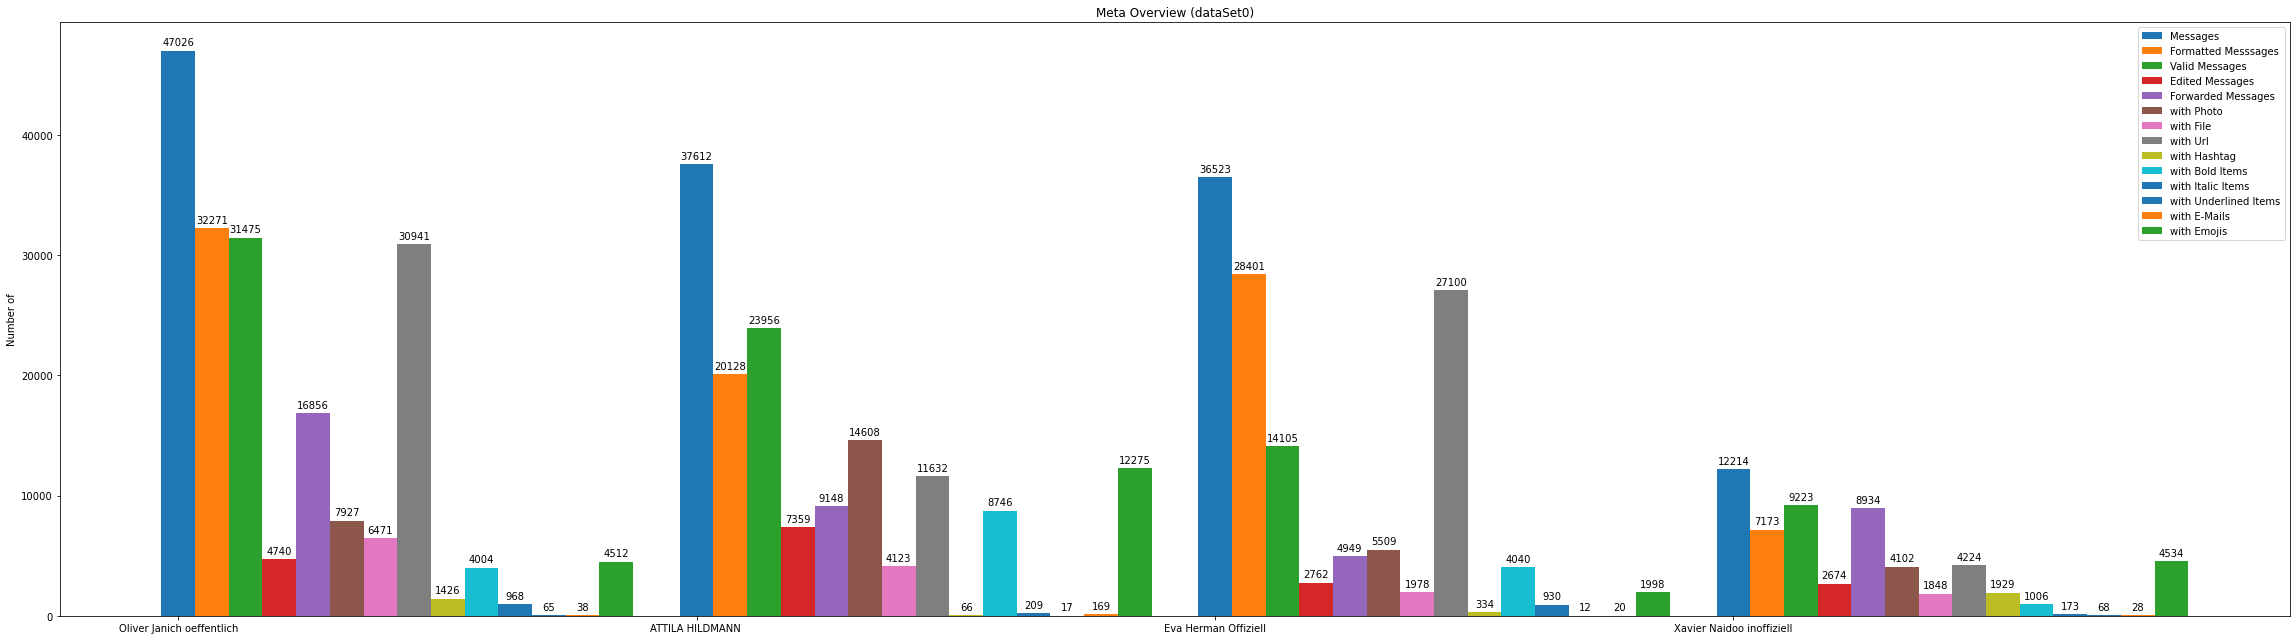

In [38]:
queryMetaPlotter(
    inputDescFilter = "dataSet0",
    configPlotWidth = 32,
    configPlotHeight = 9,
    configBarWidth = 0.065,
    outputFilename = "meta-overview-dataSet0.png"
)

In [39]:
if("dataSet1" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet1",
        configPlotWidth = 100,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1.png"
    )

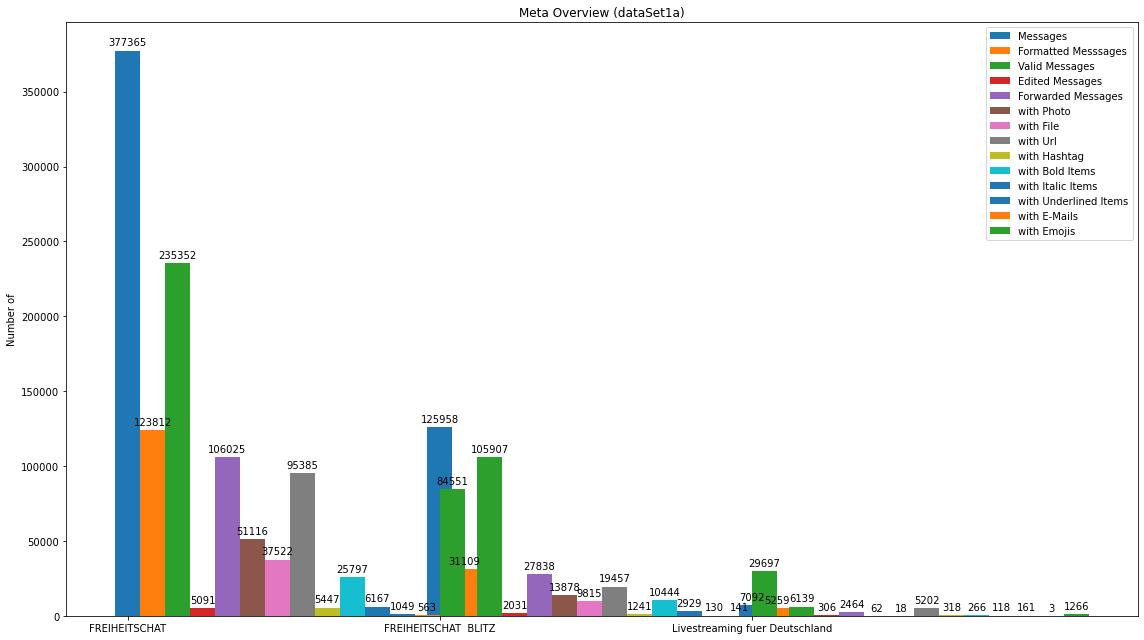

In [40]:
if("dataSet1a" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet1a",
        configPlotWidth = 16,
        configPlotHeight = 9,
        configBarWidth = 0.08,
        outputFilename = "meta-overview-dataSet1a.png"
    )

### Get text-length

In [41]:
def removeTextLengthOutliersFromDataFrame(df, interval, maxTextLength):
    df = df.copy()
    df = df[df.procTDTextLength < maxTextLength]
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within <interval> to -<interval> standard deviations in the column 'Data'.
    return df[np.abs(df.procTDTextLength-df.procTDTextLength.mean()) <= (interval*df.procTDTextLength.std())]

In [42]:
# param outputFilename set "" == no output file
def textLengthHistPlotter(outputFilename):
    dfMessages = dfAllDataMessages.copy()
    print("Number of all messages:\t\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    print("Number of valid text messages:\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = removeTextLengthOutliersFromDataFrame(
        dfMessages,
        interval = 3,               #Default is 3
        maxTextLength = 999999999   #TODO: Maybe enable max text length
        )
    print("Number of valid text messages (after outliers filtering):\t" + str(len(dfMessages.index)))

    print()
    print("Text Length Hist (after outliers filtering)")
    plt.figure(figsize=(8,4.5))
    _ = dfMessages.procTDTextLength.hist(bins=40)
    plt.title('Histogram Text Length')

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

Number of all messages:						643790
Number of valid text messages:					426157
Number of valid text messages (after outliers filtering):	417021

Text Length Hist (after outliers filtering)


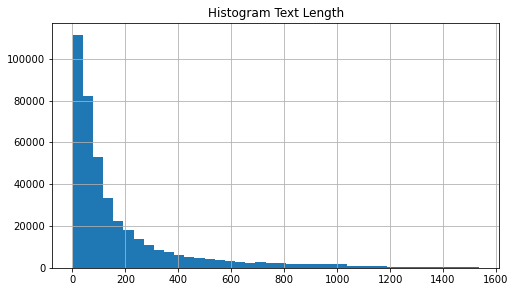

In [43]:
textLengthHistPlotter(outputFilename = "meta-text-length-hist.png")

### Compare ids and labels (has chat name changed?)

In [44]:
def compareIdsAndLabels(df):

    gloStartStopwatch("Compare ids and labels")

    dictFromTranslator  = {}
    dictActorTranslator = {}

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    df = df.set_index("date")
    df = df.sort_index()

    for index, row in df.iterrows():
        
        n_from      = row["from"]
        n_from_id   = row["from_id"]

        n_actor      = row["actor"]
        n_actor_id   = row["actor_id"]

        if(str(n_from) != "nan"):
            if(n_from_id not in dictFromTranslator):
                # Add new key
                #print("- Add from " + str(n_from_id) + "/" + str(n_from))
                dictFromTranslator[n_from_id] = n_from
            else:
                # Has changed?
                oValue = dictFromTranslator[n_from_id]
                if(oValue != n_from):
                    print("- Add changed attribute in from (prev=" + str(oValue) + "/new=" + str(n_from) + ")")
                    dictFromTranslator[n_from_id] = n_from

        if(str(n_actor) != "nan"):
            if(n_actor_id not in dictActorTranslator):
                # Add new key
                #print("- Add actor " + str(n_actor_id) + "/" + str(n_actor))
                dictActorTranslator[n_actor_id] = n_actor
            else:
                # Has changed?
                oValue = dictActorTranslator[n_actor_id]
                if(oValue != n_actor):
                    print("- Add changed attribute in actor (prev=" + str(oValue) + "/new=" + str(n_actor) + ")")
                    dictActorTranslator[n_actor_id] = n_actor

    gloStopStopwatch("Compare ids and labels")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
if(FLAG_SHORT_RUN == False):
    compareIdsAndLabels(dfAllDataMessages)

[Stopwatch started >>Compare ids and labels<<]
[Stopwatch stopped >>Compare ids and labels<< (52.772s)]


## Extract Social Graph Data

In [46]:
def resolveUrl(completeUrl):
    
    if "bit.ly" in completeUrl:

        if(gloCheckIsAlreadyCached("resolved-urls.csv", completeUrl)):
            return gloGetCached("resolved-urls.csv", completeUrl)
        else:
            print("(Resolve now >>" + completeUrl + "<<)")
            try:
                r = requests.get(completeUrl, timeout = 5)
                u = r.url
                gloAddToCache("resolved-urls.csv", completeUrl, u)
                return u
            except:
                print("(- Warn: Can not resolve (return completeUrl))")
                return completeUrl

    else:
        return completeUrl

In [47]:
# TODO: Extract hashtags in non formatted text

def extractImportantHashtags(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsHashtag == True]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["procTDHashtags"]:
            hashTagList.append(hashtagItem)

    return hashTagList

In [48]:
# Return
# a = urlList,
# b = urlResolvedList
# c = refList
# d = hostList
def extractImportantUrls(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsUrl == True]

    hostList        = list()
    urList          = list()
    urlResolvedList = list()
    refList         = list()

    counterSucHostname = 0
    counterErrHostname = 0

    for index, row in dfMessages.iterrows():
        for urlItem in row["procTDURLs"]:
            
            urlData = urlparse(str(urlItem))

            completeUrl      = urlData.geturl()
            completeHostname = urlData.hostname

            if(str(completeHostname) != "None"):
                counterSucHostname = counterSucHostname + 1
                hostList.append(str(completeHostname))

                urList.append(str(completeUrl))
                urlResolvedList.append(str(resolveUrl(completeUrl)))

                if "t.me" in str(completeHostname):
                    refList.append(str(completeUrl))
            else:
                counterErrHostname = counterErrHostname + 1

    print("Got Hostnames (suc=" + str(counterSucHostname) + "/err=" + str(counterErrHostname) + ")")

    return (urList, urlResolvedList, refList, hostList)

In [49]:
def extractImportantEmojis(df):

    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsEmojiItem == True]

    li = dfMessages.procTDEmojisDesc.values.tolist()

    retLi = list()

    # TODO: Add combinations
    for l in li:
        aString = ""
        for e in l:
            aString = aString + ":" + e 
        retLi.append(aString)

    return retLi

In [50]:
# TODO: Bug: No Hostname detected if string startsWith ! "http" in urlparse
# TODO: Feature: Url in non formatted text?
# TODO: Feature: Add other attributes (e.g. hashtags)
# TODO: Feature: Cache-Layer: Check if both set (from and from_id, actor, ...)
# TODO: Check: Duplicates refs from text

# TODO: Doc: Text ref important for finding groups
# TODO: Doc: forwared_from important for graphs

# TODO: Add emojis

# Returns
# a = Counter forwardedFromList
# b = Counter refList
# c = Counter hashtagList
# d = Counter hostList
# e = Counter emojiList
def extractSocialGraph(filePath, debugPrint, debugPrintCount):

    dfMessages = dictMessages[filePath].copy()

    hashtagList = extractImportantHashtags(dfMessages)
    emojiList = extractImportantEmojis(dfMessages)

    urlList, urlResolvedList, refList, hostList = extractImportantUrls(dfMessages)
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        df = dfMessages.copy()
        df = df[df.procEvalIsForwarded == True]
    
        for index, row in df.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            fromList.append(str(row["from"]))
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))

    configTopN = debugPrintCount

    if(debugPrint):

        print()
        print("Set top n to " + str(debugPrintCount))
        print()

        print("- Top Hosts -")
        print ("\n".join(map(str, Counter(hostList).most_common(configTopN))))
        print()
        print("- Top URLs -")
        print ("\n".join(map(str, Counter(urlList).most_common(configTopN))))
        print()
        print("- Top URLs resolved -")
        print ("\n".join(map(str, Counter(urlResolvedList).most_common(configTopN))))
        print()
        print("- Top Refs from text -")
        print ("\n".join(map(str, Counter(refList).most_common(configTopN))))
        print()
        print("- Top Refs (forwarded_from) -")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(configTopN))))
        print()
        print("- Top Refs (actor) -")
        print ("\n".join(map(str, Counter(actorList).most_common(configTopN))))
        print()
        print("- Top Refs (members) -")
        print ("\n".join(map(str, Counter(memberList).most_common(configTopN))))
        print()
        print("- Top Refs (from) -")
        print ("\n".join(map(str, Counter(fromList).most_common(configTopN))))
        print()
        print("- Top Refs (saved_from) -")
        print ("\n".join(map(str, Counter(savedFromList).most_common(configTopN))))
        print()
        print("- Top hashtags -")
        print ("\n".join(map(str, Counter(hashtagList).most_common(configTopN))))
        print()
        print("- Top emojis -")
        print ("\n".join(map(str, Counter(emojiList).most_common(configTopN))))
        print()
    
    return (Counter(forwardedFromList), Counter(refList), Counter(hashtagList),  Counter(hostList), Counter(emojiList))

In [51]:
dictSGD_ForwardedFrom = {}
dictSGD_Ref           = {}
dictSGD_Hashtag       = {}
dictSGD_Host          = {}
dictSGD_Emoji         = {}

gloStartStopwatch("Extract Social Graph Data")

for fP in dfInputFiles.inputPath:

    gloStartStopwatch("Extract Social Graph Data >>" + fP + "<<")

    a, b, c, d, e = extractSocialGraph(fP, debugPrint=False, debugPrintCount = 0)

    dictSGD_ForwardedFrom[fP]   = a
    dictSGD_Ref[fP]             = b
    dictSGD_Hashtag[fP]         = c
    dictSGD_Host[fP]            = d
    dictSGD_Emoji[fP]           = e

    gloStopStopwatch("Extract Social Graph Data >>" + fP + "<<")

gloStopStopwatch("Extract Social Graph Data")

[Stopwatch started >>Extract Social Graph Data<<]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
Got Hostnames (suc=12751/err=441)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (8.376s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
(Resolve now >>https://bit.ly/3joBCF7<<)
(- Warn: Can not resolve (return completeUrl))
Got Hostnames (suc=36363/err=630)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (16.470s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
Got Hostnames (suc=27741/err=229)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (7.171s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
(Resolve now >>https://bit.ly/2ydhZOo<<)
(-

In [52]:
def printSocialGraphDebug(filePathList):
    for fP in filePathList:
        print("Analyse now >>" + fP + "<<")
        _ = extractSocialGraph(fP, debugPrint=True, debugPrintCount=10)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
if(FLAG_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
Got Hostnames (suc=12751/err=441)

Set top n to 10

- Top Hosts -
('youtu.be', 3225)
('t.me', 902)
('www.youtube.com', 578)
('www.n-tv.de', 315)
('www.bitchute.com', 279)
('www.welt.de', 218)
('www.spiegel.de', 215)
('demos.whattheyhide.org', 197)
('amzn.to', 167)
('bit.ly', 164)

- Top URLs -
('https://bit.ly/37OCsH5', 105)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 69)
('https://demo.terminkalender.top/pc.php', 60)
('https://demos.whattheyhide.org/add', 46)
('https://youtu.be/kWpzfqW34lA', 41)
('https://demos.whattheyhide.org/', 38)
('https://t.me/ATTILAHILDMANN', 34)
('https://www.lieferando.de/attila-hildmann-vegan-food-i', 34)
('https://www.bitchute.com/video/yiU75iD2POGK/', 32)
('https://t.me/gerechtigkeitfuersvaterland', 27)

- Top URLs resolved -
('https://www.attilahildmann.de/de/shop/alle.html?pc=SAMURAI', 106)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 69)
('https://demo.terminkalender.top/pc.php', 60)


### Get Top Influencer (Downloaded?)

In [54]:
# Get Top Influencer
# param fPList      filePath List
# param configTopN  Get Top n influencer e.g. 10
def getTopInfluencer(fPList, configTopN):

    for fP in fPList:

        chatName = queryChatName(fP)

        print()
        print("Analyse Chat (Forwarded From) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # Already downloaded?
            flagDownloaded = False
            if oChatName in dfQueryMeta.qryChatName.values:
                flagDownloaded = True

            if(oChatName != "nan"):

                print(str(counter) + ": (downloaded=" + str(flagDownloaded) + ") (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1


        print()
        print("Analyse Chat (Refs) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_Ref[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = str(oChatName)
            oChatRefs    = oChatRefs

            if(oChatName != "nan"):

                print(str(counter) + " (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# TODO: Can not get all items in dataSet1

"""
# Attila Hildmann #
- Anonymous Germany - not found
- https://t.me/DEMOKRATENCHAT - no entries
- https://t.me/ChatDerFreiheit - no entries
- https://t.me/FREIHEITSCHAT2020 - not found

# Oliver Janich #
- Oliver Janich Premium - not found

# Xavier Naidoo #
- Xavier(Der VereiNiger)Naidoo😎 - not found
- https://t.me/PostAppender_bot - bot chat
"""
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath), 10)


Analyse Chat (Forwarded From) >>ATTILA HILDMANN <<
1: (downloaded=True) (refs=7448)		>>ATTILA HILDMANN <<
2: (downloaded=False) (refs=616)		>>Gerechtigkeit fuer das Vaterla<<
3: (downloaded=False) (refs=44)		>>Aktuelle Karikaturen  Goetz Wi<<
4: (downloaded=False) (refs=41)		>>   <<
5: (downloaded=False) (refs=38)		>>Anonymous Germany<<
6: (downloaded=False) (refs=34)		>>MICHAEL WENDLER <<
7: (downloaded=True) (refs=33)		>>Oliver Janich oeffentlich<<
8: (downloaded=False) (refs=28)		>>Laser Lurch<<
9: (downloaded=False) (refs=28)		>>Dawid Snowden<<
10: (downloaded=False) (refs=26)		>>Ken Jebsen  Aufklaerung und In<<

Analyse Chat (Refs) >>ATTILA HILDMANN <<
1 (refs=34)		>>https://t.me/ATTILAHILDMANN<<
2 (refs=27)		>>https://t.me/gerechtigkeitfuersvaterland<<
3 (refs=27)		>>https://t.me/FreiheitsChatDE<<
4 (refs=27)		>>https://t.me/NachrichtenWelt<<
5 (refs=23)		>>https://t.me/FREIHEITS_CHAT_BL<<
6 (refs=21)		>>https://t.me/DEMOKRATENCHAT<<
7 (refs=20)		>>https://t.me/ChatDerFreiheit<<

### Plot Social Graph

In [56]:
"""
Social Graph Layout Selector

param G Graph
param layoutSelector:

1 = Kamda Kawai Layout
2 = Spring Layout
3 = Graphviz Layout
"""
def getSocialGraphLayout(layoutSelector, G):
    switcher = {
        1: nx.kamada_kawai_layout(G.to_undirected()),
        2: nx.spring_layout(G.to_undirected(), k = 0.15, iterations=200),
        3: nx.nx_pydot.graphviz_layout(G)
    }
    return switcher.get(layoutSelector, None)

In [57]:
# TODO: Test different layouts: https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
# TODO: Try different arrows (see below): https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.ArrowStyle.html
# TODO: Check distances between nodes

"""
Draw social grah

param   G                           graph
param   layoutSelector              see above
param   configFactorEdge            e.g. 100 => weight / 100
param   configFactorNode            e.g. 10  => weight / 10
param   configArrowSize             e.g. 5
param   configPlotWidth             e.g. 16
param   configPlotHeight            e.g. 9
param   outputFilename              e.g. test.png (set "" == no output file)
param   outputTitle                 e.g. Graph (required)
"""
def drawSocialGraph(G, layoutSelector, configFactorEdge, configFactorNode, configArrowSize, configPlotWidth, configPlotHeight, outputFilename, outputTitle):
    
    gloStartStopwatch("Social Graph Plot")
    
    plt.figure(figsize=(configPlotWidth,configPlotHeight))
        
    pos = getSocialGraphLayout(layoutSelector = layoutSelector, G = G)
    
    # Clean edges
    edges       = nx.get_edge_attributes(G, "weight")
    edgesTLabel = nx.get_edge_attributes(G, "tLabel")

    clean_edges         = dict()
    clean_edges_labels  = dict()
    
    for key in edges:
        
        #Set edge weight
        clean_edges[key]        = (100 - edges[key]) / configFactorEdge

        #set edge layout
        clean_edges_labels[key] = edgesTLabel[key]
    
    # Clean nodes
    nodes       = nx.get_node_attributes(G,'weight')
    nodesTLabel = nx.get_node_attributes(G,'tLabel')
    nodesTColor = nx.get_node_attributes(G,'tColor')

    clean_nodes         = dict()
    clean_nodes_labels  = dict()
    clean_nodes_color   = dict()
    
    for key in nodes:
        
        #Set node weight        
        clean_nodes[key]        = nodes[key] / configFactorNode

        #Set node layout
        clean_nodes_labels[key] = nodesTLabel[key]
        clean_nodes_color[key]  = nodesTColor[key]
    
    # Revert DiGraph (arrows direction)
    G_rev = nx.DiGraph.reverse(G)    

    # Draw
    nx.draw(G_rev,
        pos,
        with_labels=True,
        width=list(clean_edges.values()),
        node_size=list(clean_nodes.values()),
        labels=clean_nodes_labels,
        node_color=list(clean_nodes_color.values()),
        arrowsize=configArrowSize,
        arrowstyle="wedge"
        #connectionstyle="arc3, rad = 0.1"
    )
    
    # Set labels
    _ = nx.draw_networkx_edge_labels(G_rev, pos, edge_labels=clean_edges_labels)

    plt.title(outputTitle)

    # Save and show fig
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()
    
    gloStopStopwatch("Social Graph Plot")

In [58]:
# Generates Test Graph
def generateTestGraph():

    G_weighted = nx.DiGraph()

    G_weighted.add_edge("N1", "N2", weight=100-30,  tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N1", "N3", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")
    G_weighted.add_edge("N1", "N4", weight=100-60,  tLabel = "(≙" + str(100-60) + ")")

    G_weighted.add_edge("N4", "N5", weight=100-80,  tLabel = "(≙" + str(100-80) + ")")
    G_weighted.add_edge("N4", "N6", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")

    G_weighted.add_edge("N4", "N7", weight=100-30,   tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N7", "N4", weight=100-70,   tLabel = "(≙" + str(100-70) + ")")

    G_weighted.add_node("N1", weight=500.0, tLabel = "N1-T", tColor="red")
    G_weighted.add_node("N2", weight=500.0, tLabel = "N2-T", tColor="blue")
    G_weighted.add_node("N3", weight=500.0, tLabel = "N3-T", tColor="blue")
    G_weighted.add_node("N4", weight=500.0, tLabel = "N4-T", tColor="red")
    G_weighted.add_node("N5", weight=500.0, tLabel = "N5-T", tColor="red")
    G_weighted.add_node("N6", weight=500.0, tLabel = "N6-T", tColor="red")
    G_weighted.add_node("N7", weight=500.0, tLabel = "N7-T", tColor="blue")

    return G_weighted

In [59]:
# Add node weight to dict
# Only adds new weight if newWeight > oldWeight
def addSocialGraphNodeWeight(chatName, chatWeight, targetDict):
    
    if(chatName in targetDict):
        oldWeight = targetDict[chatName]
        if(chatWeight > oldWeight):
            targetDict[chatName] = chatWeight
    else:
        targetDict[chatName] = chatWeight

In [60]:
"""
Generate social graph

param   configTopNInfluencer        e.g. For top 10 = 10
param   configMinRefs               e.g. 1 must have > 1 % forwarded messages
param   listFilePaths               List process filePaths
param   socialGraphTargetDict       e.g. forwarded from dict or hashtag dict
param   socialGraphTargetAttribute  e.g. procEvalIsForwarded (for calc percent)
param   configFlagDebugLabel        e.g. show debug info on label
"""
def generateSocialGraph(configTopNInfluencer, configMinRefs, listFilePaths, socialGraphTargetDict, socialGraphTargetAttribute, configFlagDebugLabel):
    
    # Save node weights to dict
    dictSocialNodeWeights   = dict()

    # Flag downloaded nodes (exact node weight)
    dictExactNodesLabels    = {}
    
    gloStartStopwatch("Social Graph")
    
    # Generate directed graph
    G_weighted = nx.DiGraph()
    
    print("- Add edges")
    for fP in listFilePaths:
        
        # Query own params
        chatName                        = queryChatName(fP)
        chatNumberOfMessages            = queryNumberOfMessages(fP)
        chatNumberOfTargetMessages      = queryNumberOfMessagesByAttEqTrue(fP, socialGraphTargetAttribute)

        gloStartStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
        # Add exact node size (chat downloaded) and flag node
        addSocialGraphNodeWeight(chatName, chatNumberOfMessages, dictSocialNodeWeights)
        dictExactNodesLabels[chatName] = str(chatName) + "\n=[" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + "]"

        # Extract social graph data and get top influencer
        socialGraphData = socialGraphTargetDict[fP]
        socialGraphData = socialGraphData.most_common(configTopNInfluencer)
        
        # Iterate over forwarder
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # If has forwarder
            if(oChatName != "nan"):
        
                # Calc percent (forwarded_messages)
                per = (oChatRefs/chatNumberOfTargetMessages) * 100

                # Filter unimportant forwarders
                if(per > configMinRefs):
                
                    # Add estimanted node size (chat not downloaded)
                    addSocialGraphNodeWeight(oChatName, oChatRefs, dictSocialNodeWeights)

                    # Invert percent (distance)
                    wei = 100 - per

                    # Label
                    if(configFlagDebugLabel):
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + "≙" + str(round(wei, 3)) + ")"
                    else:
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + ")"

                    # Add edge
                    G_weighted.add_edge(
                        chatName,
                        oChatName,
                        weight=wei,
                        tLabel = lab
                    )

        gloStopStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
    print("- Add different nodes")
    for aNode in dictSocialNodeWeights:
        
        # Query node params
        nodeName   = str(aNode)
        nodeWeight = dictSocialNodeWeights[aNode]

        # Set defaults
        tValueColor = "#ff8000"
        tLabel = str(nodeName) + "\n≈[" + str(nodeWeight) + "]"

        # Overwrite (if chat downloaded = exact weight)
        if(nodeName in dictExactNodesLabels):
            tValueColor = "#0080ff"
            tLabel = dictExactNodesLabels[nodeName]
        
        G_weighted.add_node(
            nodeName,
            weight=nodeWeight,
            tLabel = tLabel,
            tColor=tValueColor
        )
        
    gloStopStopwatch("Social Graph")
        
    return G_weighted

#### Test Graphs

In [61]:
generatedTestGraph = generateTestGraph()

[Stopwatch started >>Social Graph Plot<<]


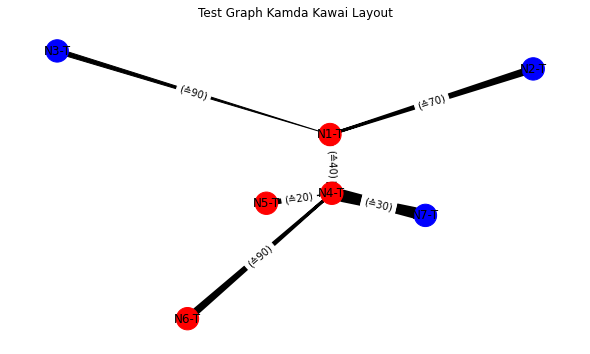

[Stopwatch stopped >>Social Graph Plot<< (0.666s)]


In [62]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=1,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Kamda Kawai Layout"
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph Plot<<]


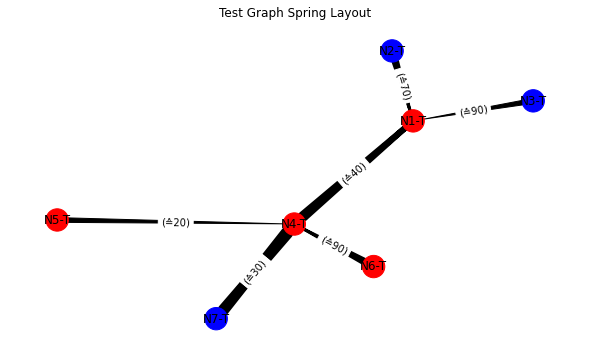

[Stopwatch stopped >>Social Graph Plot<< (0.440s)]


In [63]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=2,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Spring Layout"
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph Plot<<]


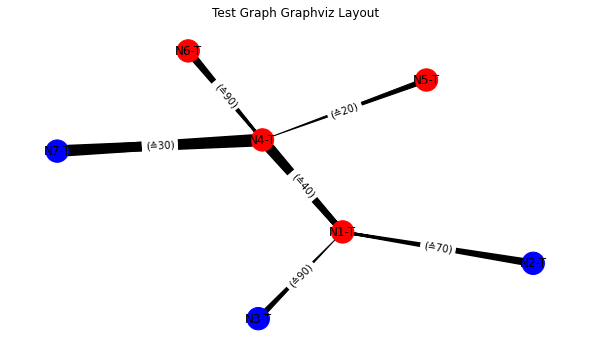

[Stopwatch stopped >>Social Graph Plot<< (0.465s)]


In [64]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=3,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Graphviz Layout"
)

#### Real Graph (ForwardedFrom)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (9148/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (9148/37612 messages)<< (0.006s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(16856/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(16856/47026 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(4949/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(4949/36523 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(8934/12214 messages)<<]
[Stopwatch stopped >>S

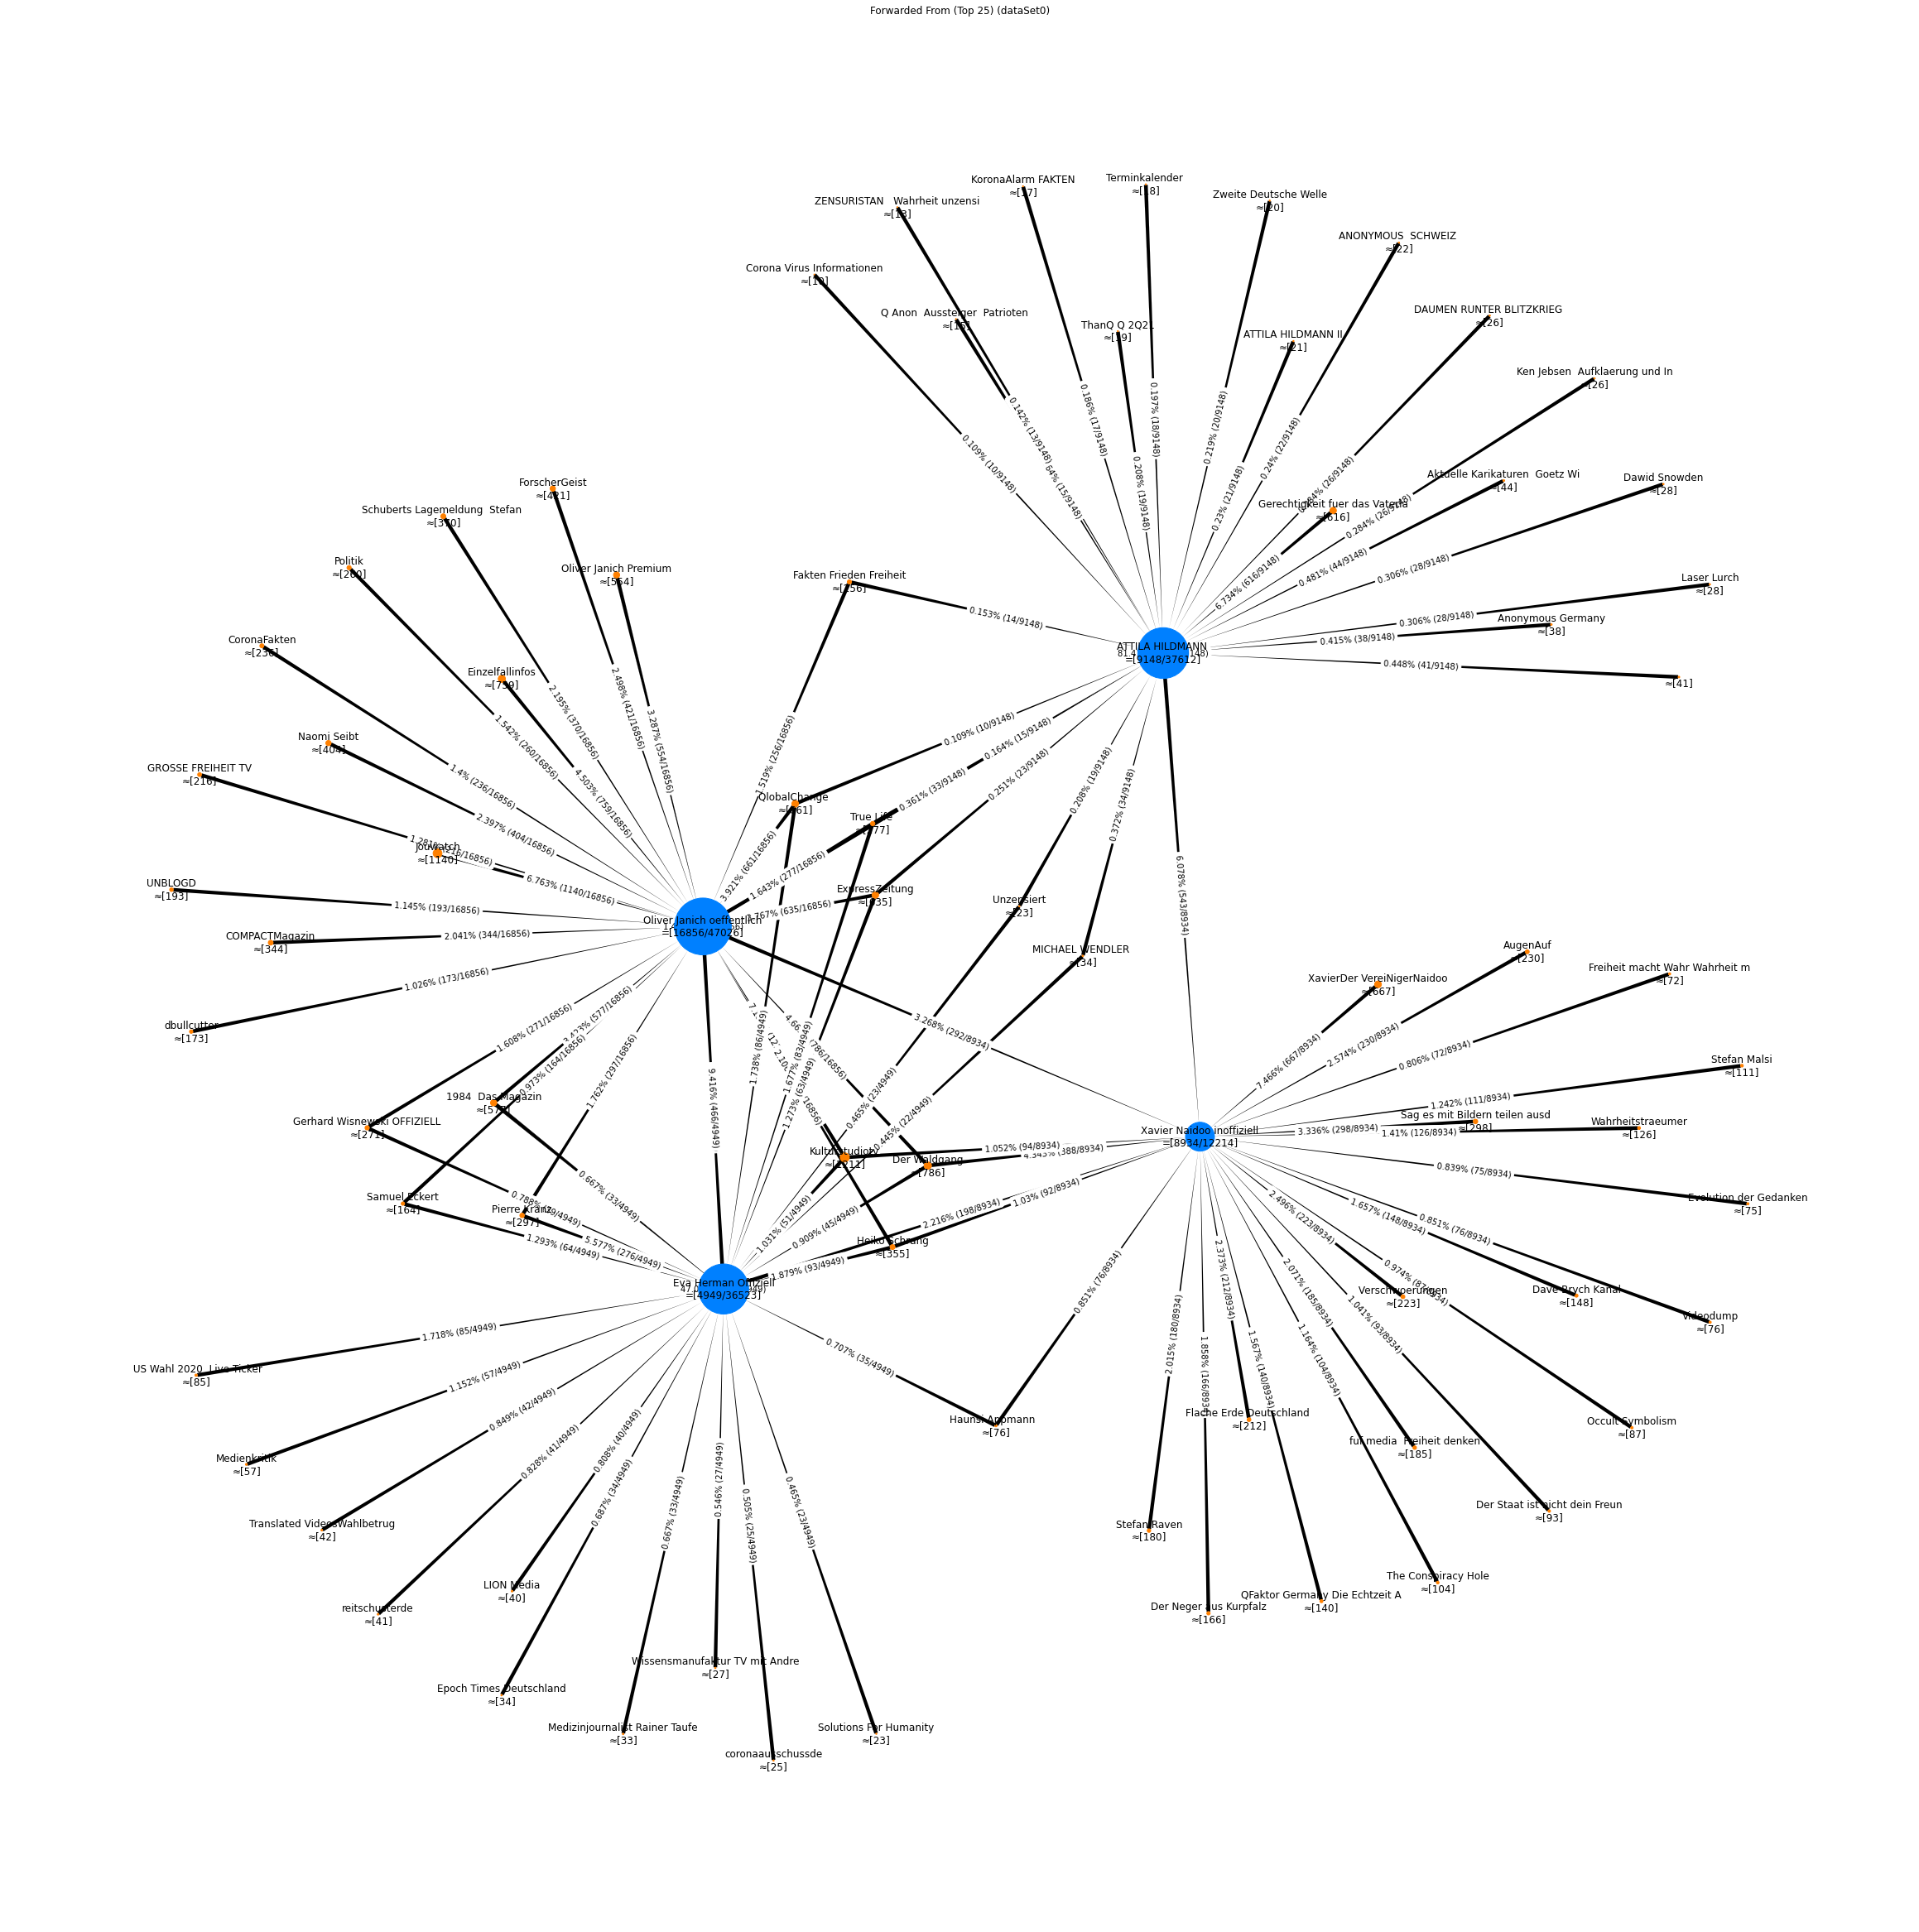

[Stopwatch stopped >>Social Graph Plot<< (5.145s)]


In [65]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,       
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_ForwardedFrom,
        socialGraphTargetAttribute = "procEvalIsForwarded",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-forwarded-from.png",
    outputTitle = "Forwarded From (Top 25) (dataSet0)"
)

#### Real Graph (Hashtag)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (66/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (66/37612 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(1426/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(1426/47026 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(334/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(334/36523 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(1929/12214 messages)<<]
[Stopwatch stopped >>SG-Extrac

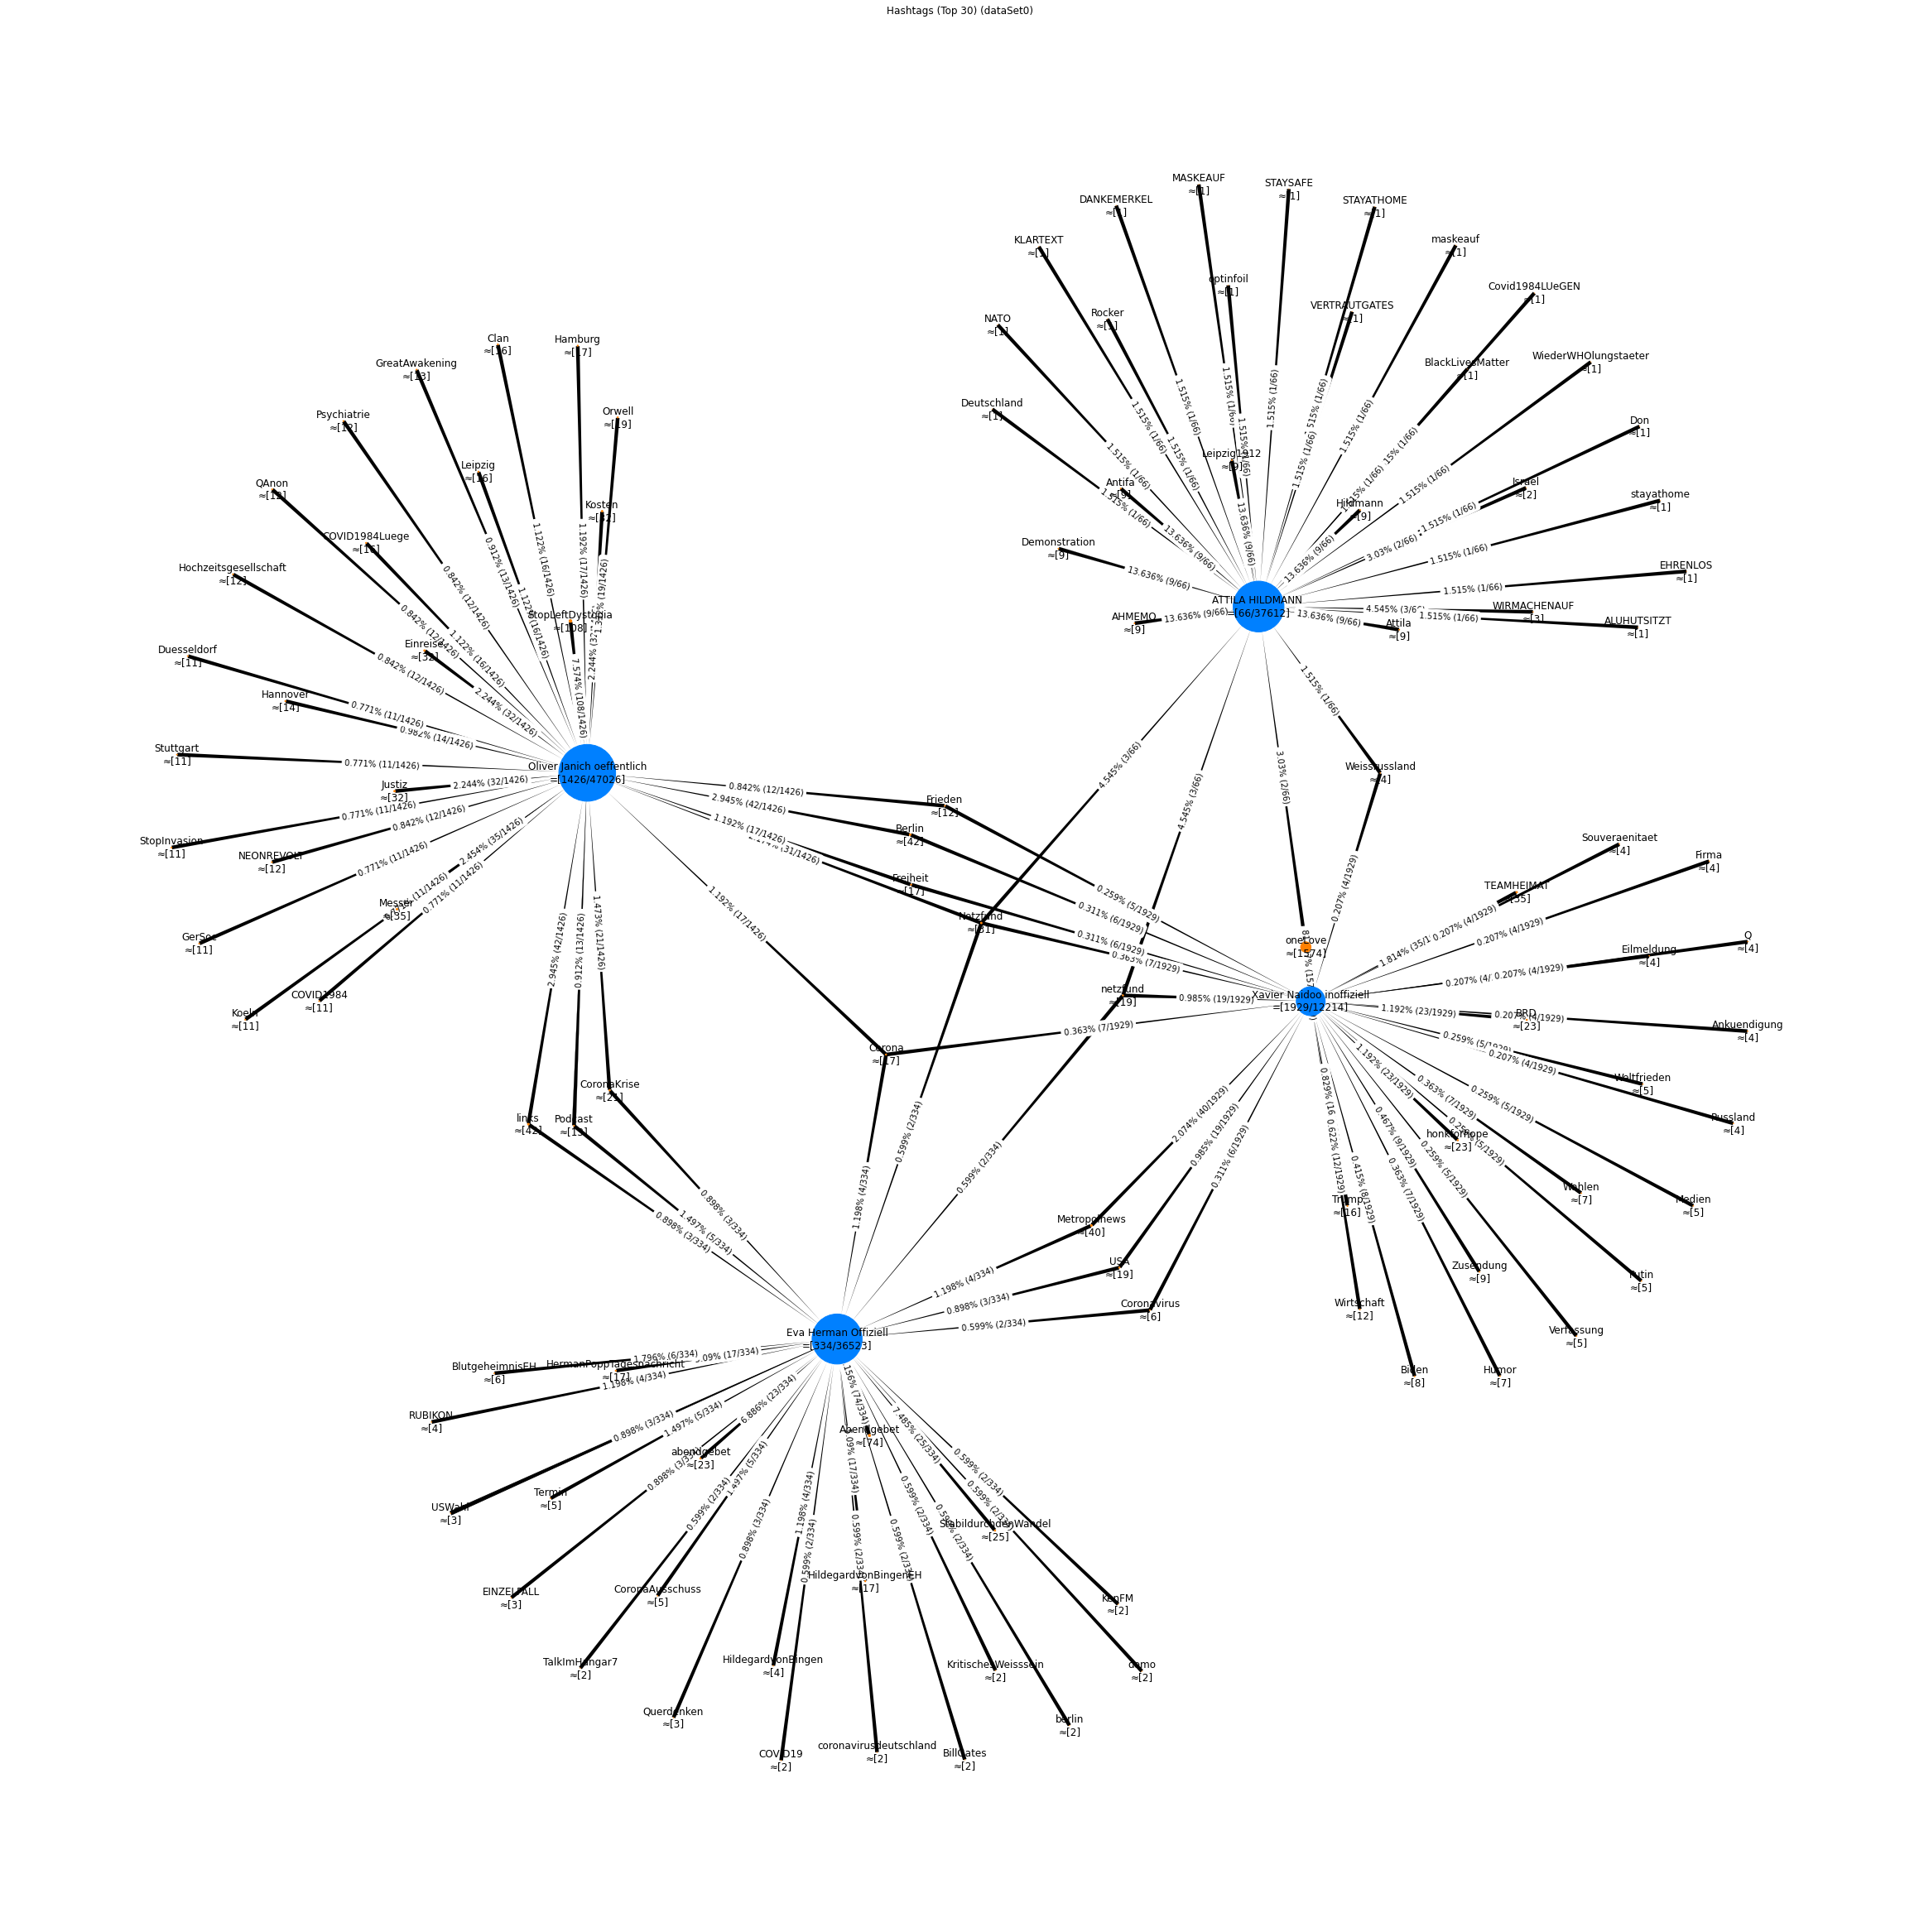

[Stopwatch stopped >>Social Graph Plot<< (6.552s)]


In [66]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 30,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Hashtag,
        socialGraphTargetAttribute = "procEvalContainsHashtag",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-hashtag.png",
    outputTitle = "Hashtags (Top 30) (dataSet0)"
)

#### Real Graph (Hosts)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (11632/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (11632/37612 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(30941/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(30941/47026 messages)<< (0.004s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(27100/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(27100/36523 messages)<< (0.003s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(4224/12214 messages)<<]
[Stopwatch stopped

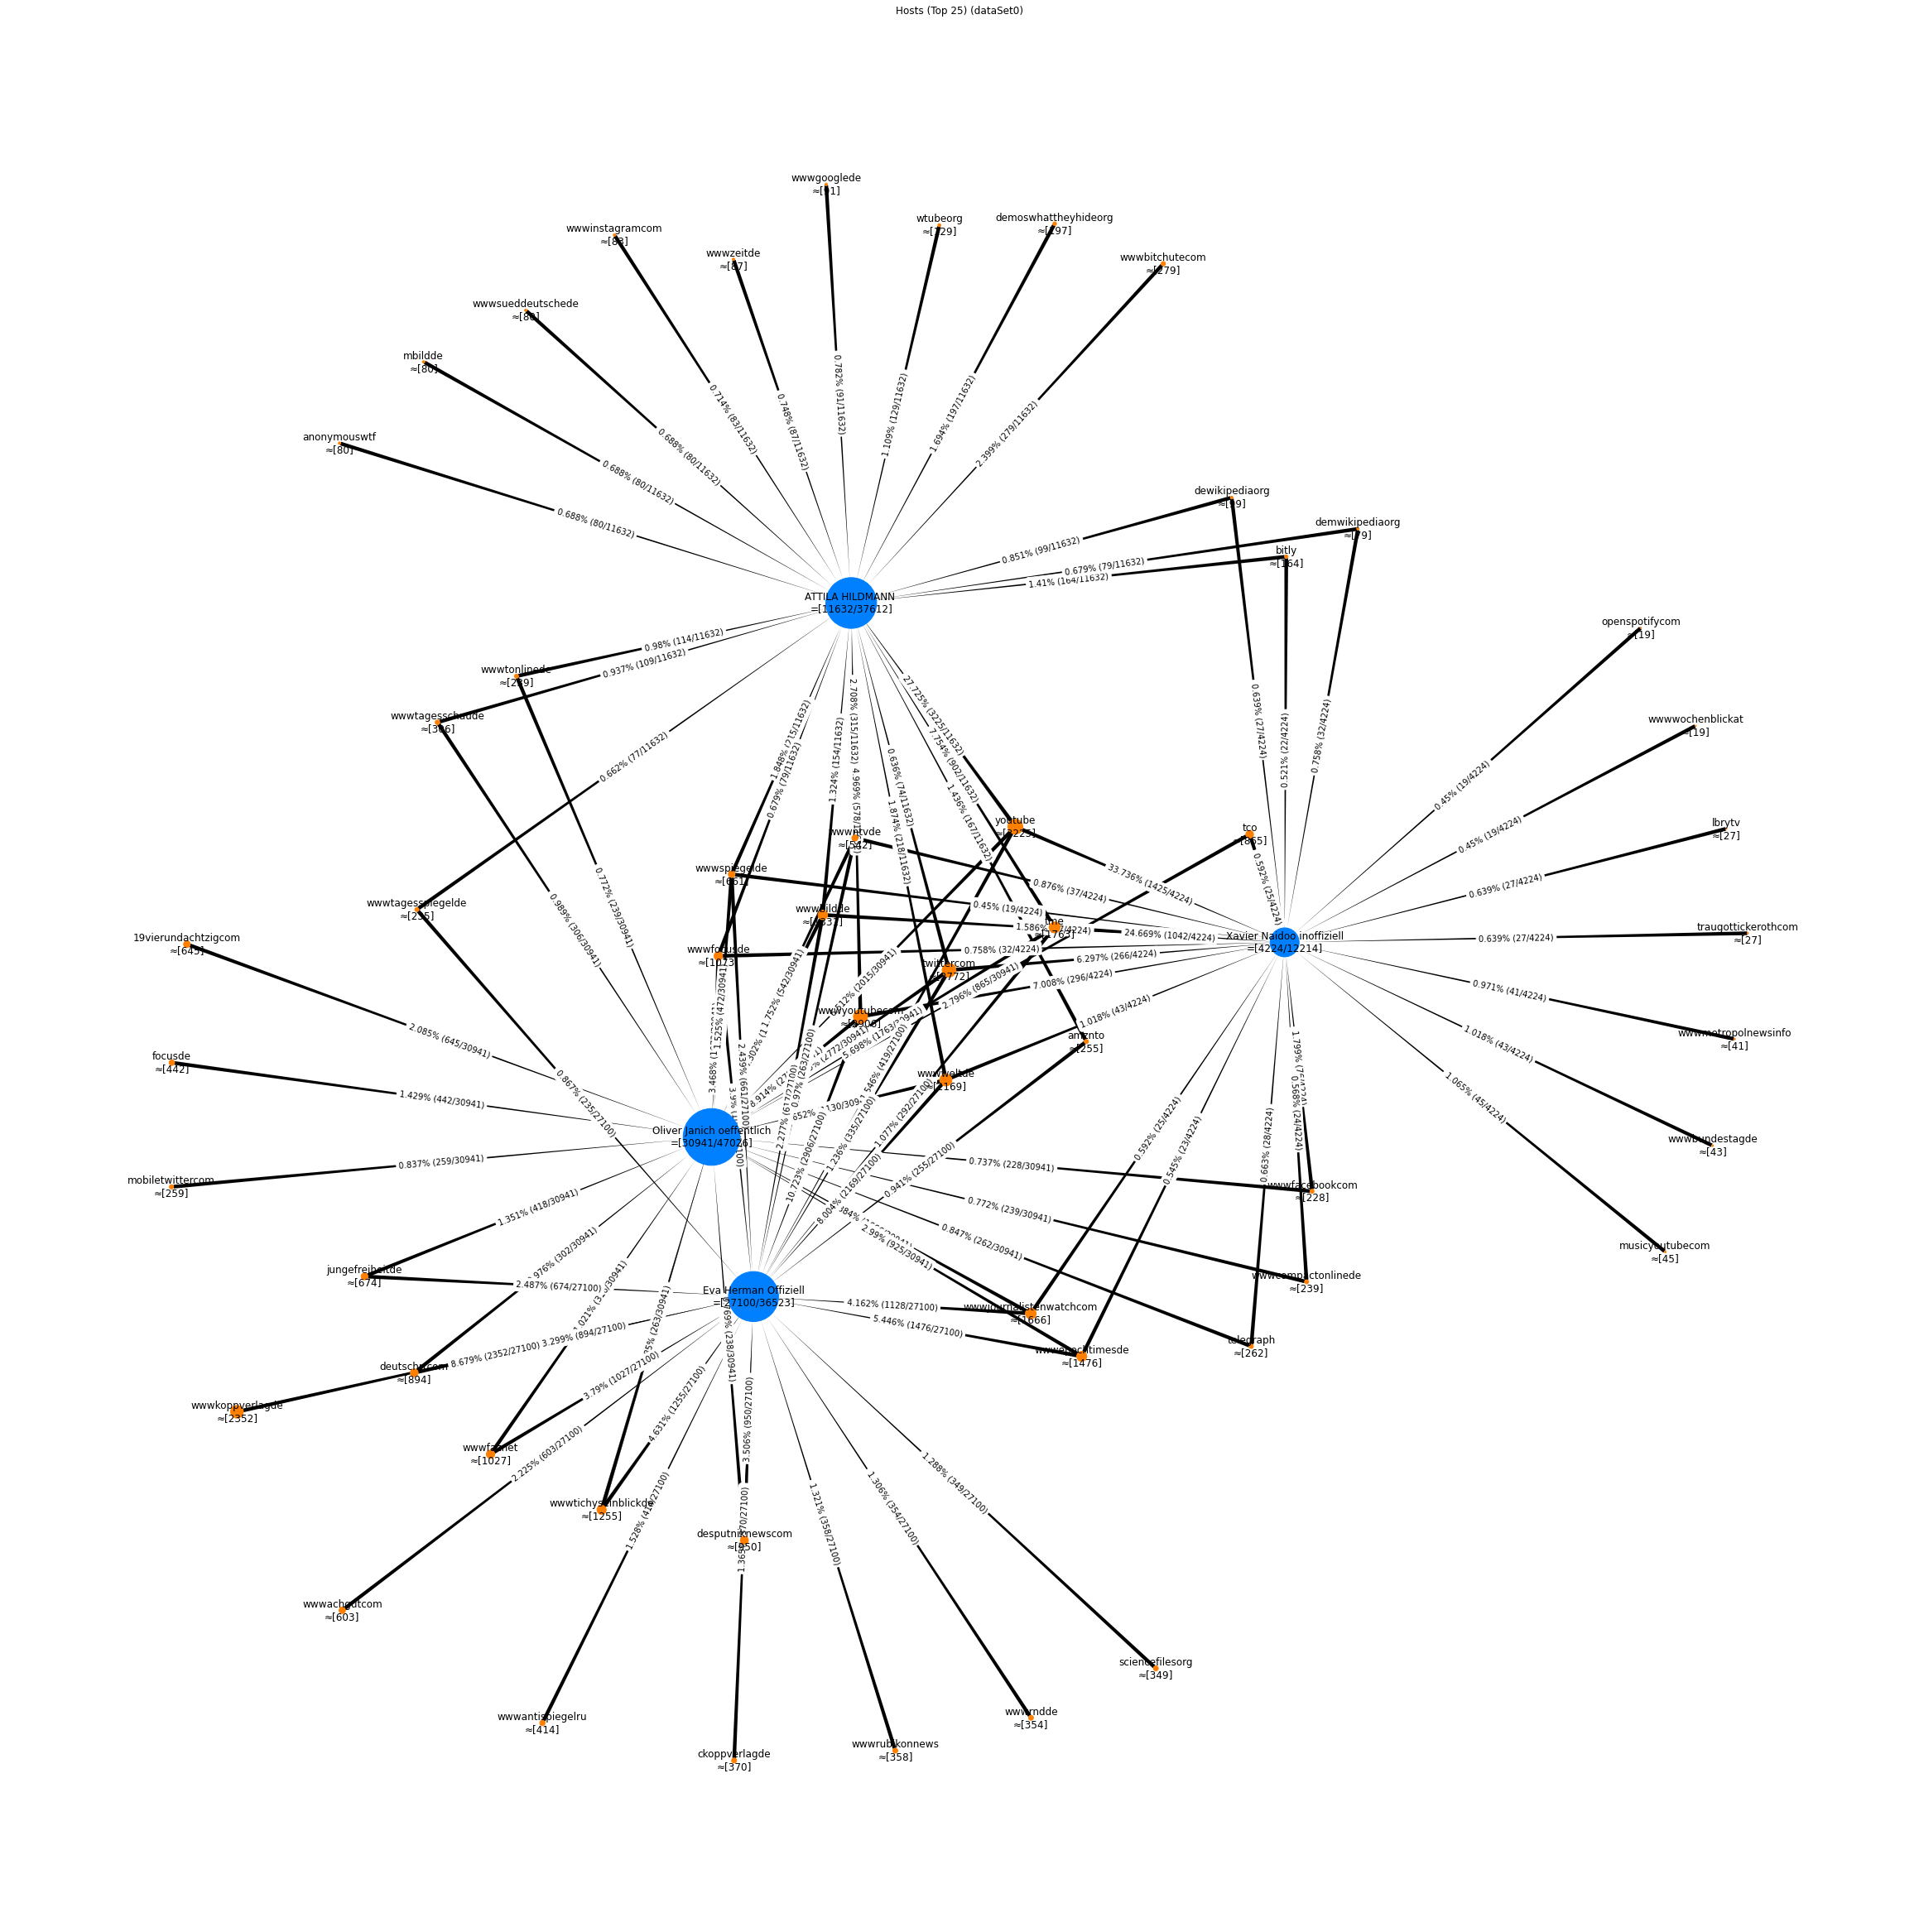

[Stopwatch stopped >>Social Graph Plot<< (4.763s)]


In [67]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Host,
        socialGraphTargetAttribute = "procEvalContainsUrl",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-host.png",
    outputTitle = "Hosts (Top 25) (dataSet0)"
)

#### Real Graph (Emojis)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (12275/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (12275/37612 messages)<< (0.008s)]
[Stopwatch started >>SG-Extract Oliver Janich oeffentlich(4512/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich oeffentlich(4512/47026 messages)<< (0.006s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(1998/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(1998/36523 messages)<< (0.015s)]
[Stopwatch started >>SG-Extract Xavier Naidoo inoffiziell(4534/12214 messages)<<]
[Stopwatch stopped >>S

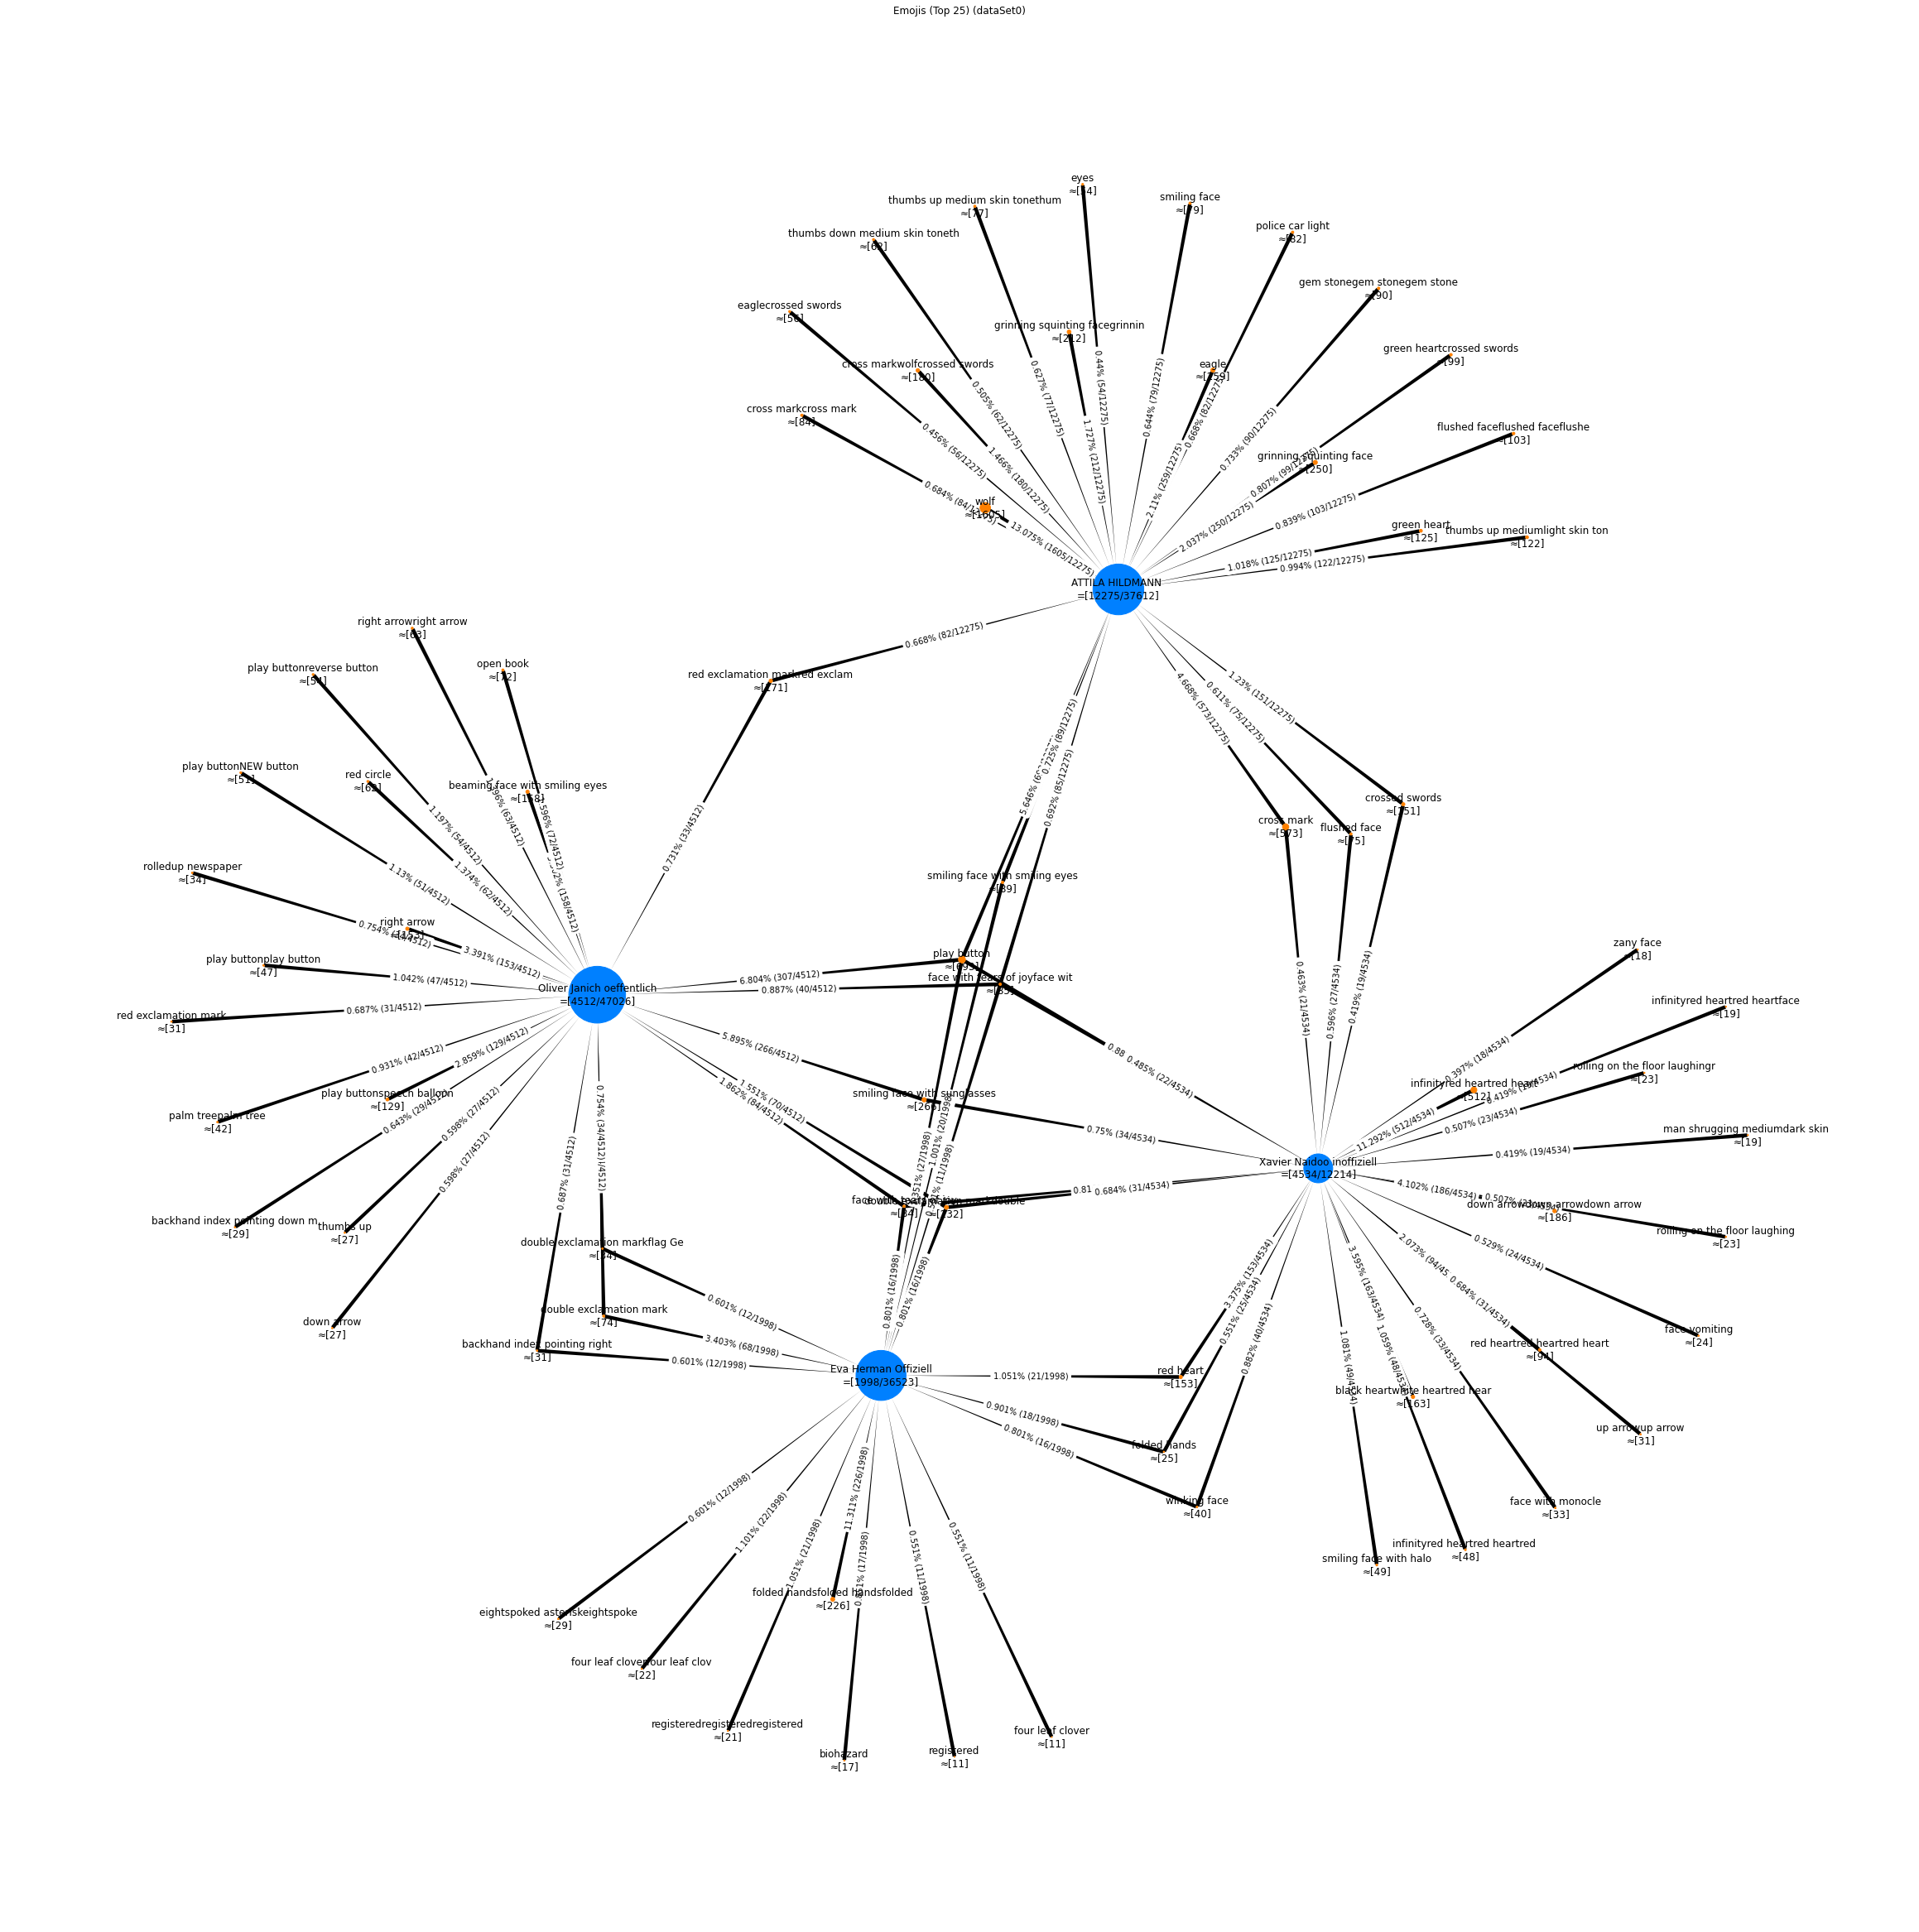

[Stopwatch stopped >>Social Graph Plot<< (4.916s)]


In [68]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Emoji,
        socialGraphTargetAttribute = "procEvalContainsEmojiItem",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-emoji.png",
    outputTitle = "Emojis (Top 25) (dataSet0)"
)

## Time Tools

In [69]:
"""
param   targetDate      e.g. 1970-01-01
param   fP              filePath
param   highlightWord   set "" = no filter
"""
def queryNumberOfMessagesByDate(targetDate, fP, highlightWord):

    df = dictMessages[fP].copy()

    df = df[df.procEvalIsValidText == True]

    df["date"] = pd.to_datetime(df["date"])
    
    df = df[df.date <= targetDate]

    if(highlightWord != ""):
        df = df[df.procTDCleanText.str.contains(highlightWord)]

    l = len(df.index)

    if(l > 0):
        return l
    else:
        return np.nan

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
"""
param   filePathList
param   outputFilename  set "" = no output file
param   highlightWords  list of highlight words (leave empty if not used)
"""
def drawTimePlot(filePathList, outputFilename, highlightWords):

    gloStartStopwatch("Time Plot")

    # Set plot style
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 9))

    df = pd.DataFrame(
        index=pd.date_range( #m/d/y
            start='9/1/2018',
            end='2/1/2021',
            freq="1D"
            )
        )

    # Add date to process
    df["date"] = df.index

    vLineHeight = -1

    for fP in filePathList:
        gloStartStopwatch("Time Plot >>" + fP + "<<")

        # Set vline height
        currentHeight = queryNumberOfMessagesByAttEqTrue(fP, "procEvalIsValidText")
        if(currentHeight > vLineHeight):
            vLineHeight = currentHeight

        # Plot
        plt.plot(
            df.index, #x
            df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = ""), axis=1), #y
            label = queryChatName(fP) #label
        )

        # Plot High Light Word Graph
        for hWord in highlightWords:
            plt.plot(
                df.index, #x
                df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = hWord), axis=1), #y
                label = queryChatName(fP) + " usage of '" + hWord + "'" #label
            ) 

        gloStopStopwatch("Time Plot >>" + fP + "<<")

    # yy - mm - dd
    # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
    plt.vlines(x = ["2020-01-27"], ymin=0, ymax=vLineHeight, color="grey", ls='--', label="Corona Patient Zero Germany")
    plt.vlines(x = ["2020-03-23"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
    plt.vlines(x = ["2020-11-02"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
    plt.vlines(x = ["2020-12-16"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

    _ = plt.legend()

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    gloStopStopwatch("Time Plot")

[Stopwatch started >>Time Plot<<]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (94.535s)]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (120.832s)]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (71.440s)]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (31.359s)]
[Stopwatch stopped >>Time Plot<< (318.378s)]


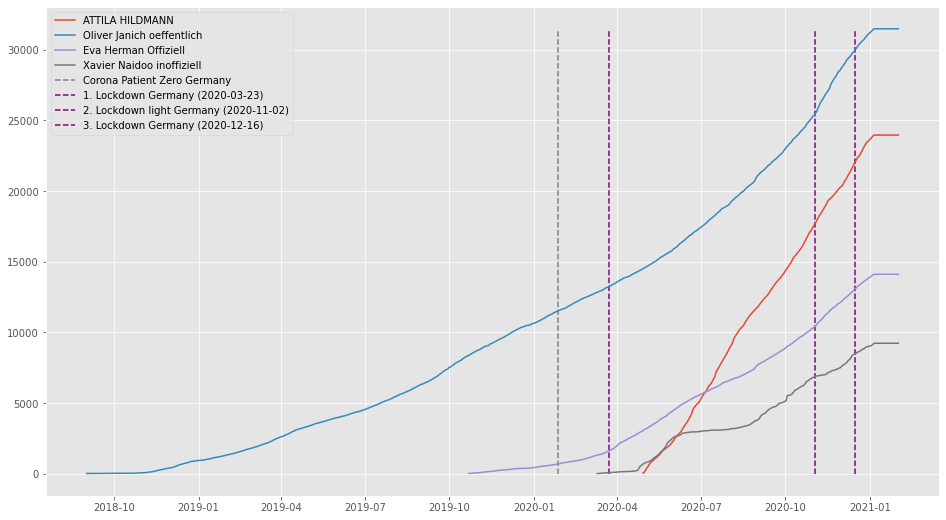

In [71]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        outputFilename = "time-plot-dataSet0.png",
        highlightWords = []
    )

In [72]:
if(FLAG_SHORT_RUN == False):
    if("dataSet1" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1"].inputPath),
            outputFilename = "time-plot-dataSet1.png",
            highlightWords = []
        )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
if(FLAG_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath),
            outputFilename = "time-plot-dataSet1a.png",
            highlightWords = []
        )

## Word Clouds

In [78]:
def getStopWordsList(filterList):

    stopwWorldsList = []

    deWordsList = nltk.corpus.stopwords.words('german')

    enWordsList = nltk.corpus.stopwords.words('english')

    aStopwords = []
    with open(dir_var + "additionalStopwords.txt") as file:
        for line in file: 
            line = line.strip()
            if(line != ""):
                aStopwords.append(line)

    for s in filterList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in deWordsList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in enWordsList:
        stopwWorldsList.append(s)

    for s in aStopwords:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    return stopwWorldsList

In [79]:
# TODO: Improve cleaning
def generateTextFromChat(df):
    df = df.copy()
    df = df[df.procEvalIsValidText == True]
    
    # Iterate over text (global text from group)
    textList = []
    for index, row in df.iterrows():
        textList.append(" " + row["procTDSafeText"])
        
    textString = ''.join(textList)

    return textString

In [80]:
# TODO: Difference capital letters?
# TODO: Context?
# TODO: Improve stop words
# TODO: Only on valid text?

"""
WordCloud

param   targetDataFrame     DataFrame
param   outputFilename      filename in outputdir (set "" == no output file)
param   filterList          Exclude list
param   flagShow            Set true == show wordcloud
param   configPlotWidth     e.g. 1920
param   configPlotHeight    e.g. 1080
"""
def generateWordCloud(targetDataFrame, outputFilename, filterList, flagShow, configPlotWidth, configPlotHeight):
    
    gloStartStopwatch("Word Cloud")

    dfMessages = targetDataFrame.copy()
    
    print("- Start transform text to global text string")
    textString = generateTextFromChat(dfMessages)
    
    stopWordsList = getStopWordsList(filterList)
    
    # Generate word cloud and save it to file
    print("- Start generate cloud")
    wordcloud = WordCloud(
                background_color="black",
                width=configPlotWidth,
                height=configPlotHeight,
                stopwords=stopWordsList
            ).generate(textString)

    if(outputFilename != ""):
        wordcloud.to_file(dir_var_output + outputFilename)
    
    if(flagShow):
        # Show top 20
        print()
        print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
        print()
        
        # Show word cloud
        print("- Start generate figure")
        plt.figure(figsize=(14, 14))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()
    
    gloStopStopwatch("Word Cloud")

### Single Mode

In [81]:
# Oliver Janich öffentlich (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
        "wordcloud-oliver-janich.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [82]:
# ATTILA HILDMANN OFFICIAL (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        "wordcloud-attila-hildmann.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [83]:
# Eva Herman Offiziell (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        "wordcloud-eva-herman.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [84]:
# Xavier Naidoo (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        "wordcloud-xavier-naidoo.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [85]:
# Just for test purposes
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dfAllDataMessages,
        "",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

### Auto Mode (Batch)

In [86]:
def extractTimePeriodDataFrame(df, timeStart, timeStop):

    print("- Got Start " + str(timeStart) + " and Stop " + str(timeStop))

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    dfNew = df[df.date <= timeStop]
    dfNew = dfNew[dfNew.date >= timeStart]

    dfNew = dfNew.set_index("date")
    dfNew = dfNew.sort_index()

    return dfNew

In [87]:
def generateWCPeriod():
    return list(pd.date_range( #m/d/y
            start='1/1/2018',
            end='2/1/2021',
            #freq="W-MON",
            freq="1M"
            ))

In [88]:
"""
Wrapper WordCloud

param   fP  filePath
param   label e.g. chatName
param   filterList additional stopWords
"""
def generateWordCloudAuto(fP, label, filterList):

    gloStartStopwatch("Generate World Cloud Auto >>" + fP + "<<")

    periods = generateWCPeriod()

    dictSaved = {}

    prevStart = periods[0]

    for period in periods:

        stop = period

        e = extractTimePeriodDataFrame(dictMessages[fP], timeStart = prevStart, timeStop = stop)

        if(prevStart != stop and len(e.index) > 0):
            fileName = "autoWordCloud/" + queryChatName(fP) + "-" + str(prevStart) + "-" + str(stop) + ".png"
            generateWordCloud(
                e,
                fileName,
                filterList,
                flagShow = False,
                configPlotWidth = 1280,
                configPlotHeight = 720
            )
            print("- Save file " + fileName)
            dictSaved[fileName] = str(prevStart) + " - " + str(stop)

        else:
            print("- Start and Stop equal or no message found")

        prevStart = stop

    gloWriteDictToFile("auto-wordcloud-" + label + ".csv", dictSaved)

    gloStopStopwatch("Generate World Cloud Auto >>" + fP + "<<")

In [89]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-janich",
        label = "oliver-janich",
        filterList = []
    )

In [90]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-hildmann",
        label = "attila-hildmann",
        filterList = []
    )

In [91]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-evaherman",
        label = "eva-herman",
        filterList = []
    )

In [92]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-xavier",
        label = "xavier-naidoo",
        filterList = []
    )

## N Grams

In [93]:
def generateNGram(text, n):
    # https://albertauyeung.github.io/2018/06/03/generating-ngrams.html
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    
    return list(ngrams(tokens, n))

In [94]:
def generateNGramChat(fP, n, mostCommon):
    return Counter(
        generateNGram(
            generateTextFromChat(dictMessages[fP]),
            n = n
        )
    ).most_common(mostCommon)

In [95]:
def generateNGramAuto(filePathList, n, mostCommon):
    for fP in filePathList:

        print()
        print("Analyse now >>" + fP + "<<")

        c = generateNGramChat(
            fP,
            n = n,
            mostCommon = mostCommon
        )

        print ("\n".join(map(str, c)))

In [96]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 2,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folgen', 'attilahildmann'), 2061)
(('dem', 'wolf'), 1709)
(('wolf', 'attilahildmann'), 1708)
(('folg', 'dem'), 1707)
(('in', 'der'), 1343)
(('und', 'die'), 997)
(('fuer', 'die'), 806)
(('in', 'den'), 805)
(('es', 'ist'), 804)
(('https', 't'), 621)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('in', 'der'), 4109)
(('in', 'den'), 2353)
(('fuer', 'die'), 2182)
(('dass', 'die'), 1621)
(('und', 'die'), 1613)
(('von', 'der'), 1369)
(('auf', 'die'), 1338)
(('mit', 'dem'), 1265)
(('mit', 'der'), 1252)
(('in', 'deutschland'), 1214)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('in', 'der'), 3069)
(('in', 'den'), 1786)
(('fuer', 'die'), 1508)
(('und', 'die'), 1285)
(('auf', 'die'), 1084)
(('mit', 'dem'), 1001)
(('dass', 'die'), 980)
(('von', 'der'), 952)
(('ueber', 'die'), 876)
(('liebe', 'eva'), 872)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<
(('xavier', 'naidoo'), 2876)
(('onelo

In [97]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 3,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('dem', 'wolf', 'attilahildmann'), 1708)
(('folg', 'dem', 'wolf'), 1707)
(('https', 't', 'me'), 621)
(('attilahildmann', 'chat', 'beitreten'), 504)
(('wolf', 'attilahildmann', 'chat'), 501)
(('chat', 'beitreten', 'chatderfreiheit'), 499)
(('https', 'youtu', 'be'), 443)
(('das', 'deutsche', 'volk'), 340)
(('teilen', 'folgen', 'attilahildmann'), 322)
(('www', 'attilahildmann', 'de'), 263)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('in', 'den', 'usa'), 248)
(('im', 'premium', 'kanal'), 203)
(('kommentierung', 'meiner', 'videos'), 198)
(('und', 'kommentierung', 

In [98]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 4,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folg', 'dem', 'wolf', 'attilahildmann'), 1707)
(('dem', 'wolf', 'attilahildmann', 'chat'), 501)
(('wolf', 'attilahildmann', 'chat', 'beitreten'), 501)
(('attilahildmann', 'chat', 'beitreten', 'chatderfreiheit'), 496)
(('www', 'attilahildmann', 'de', 'alles'), 228)
(('attilahildmann', 'de', 'alles', 'pc'), 228)
(('folgt', 'uns', 'auf', 'gerechtigkeitfuersvaterland'), 207)
(('de', 'alles', 'pc', 'topbioneu'), 185)
(('b', 'nai', 'b', 'rith'), 179)
(('zum', 'ersten', 'mal', 'bei'), 166)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('und', 'kommentierung', 'meiner

In [99]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 5,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folg', 'dem', 'wolf', 'attilahildmann', 'chat'), 501)
(('dem', 'wolf', 'attilahildmann', 'chat', 'beitreten'), 501)
(('wolf', 'attilahildmann', 'chat', 'beitreten', 'chatderfreiheit'), 493)
(('www', 'attilahildmann', 'de', 'alles', 'pc'), 228)
(('attilahildmann', 'de', 'alles', 'pc', 'topbioneu'), 185)
(('zum', 'ersten', 'mal', 'bei', 'mir'), 166)
(('die', 'zum', 'ersten', 'mal', 'bei'), 152)
(('gutschein', 'fuer', 'alle', 'die', 'zum'), 149)
(('fuer', 'alle', 'die', 'zum', 'ersten'), 149)
(('alle', 'die', 'zum', 'ersten', 'mal'), 149)

Analyse now >>DS-05-01-2021/ChatExport

In [100]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 6,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folg', 'dem', 'wolf', 'attilahildmann', 'chat', 'beitreten'), 501)
(('dem', 'wolf', 'attilahildmann', 'chat', 'beitreten', 'chatderfreiheit'), 493)
(('www', 'attilahildmann', 'de', 'alles', 'pc', 'topbioneu'), 185)
(('die', 'zum', 'ersten', 'mal', 'bei', 'mir'), 152)
(('gutschein', 'fuer', 'alle', 'die', 'zum', 'ersten'), 149)
(('fuer', 'alle', 'die', 'zum', 'ersten', 'mal'), 149)
(('5', 'gutschein', 'fuer', 'alle', 'die', 'zum'), 148)
(('alle', 'die', 'zum', 'ersten', 'mal', 'bei'), 148)
(('zum', 'ersten', 'mal', 'bei', 'mir', 'bestellen'), 145)
(('bestellen', 'www', 'attil

## Topic Modeling

Overview Topic Modeling
https://nlpforhackers.io/topic-modeling/

- LDA (Probabilistic Graphical Models)
- LSA or LSI (Linear Algebra Singular Value Decomposition)
- NMF (Linear Algebra Non-Negative Matrix Factorization)

### Latent Dirichlet Allocation (LDA) with Gensim

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [101]:
# TODO: Get clean words from it (arrays)
def sendToWords(sentences):
    for sentence in sentences:
        # deacc= removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def removeStopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
"""
return  (lda_model, corpus, id2word)
"""
def processLda(df, num_topics, debugPrint, filterList):

    df = df.copy()

    df = df[df.procEvalIsValidText == True]

    df = df[["date", "procTDSafeLowercaseText"]]

    df = df.set_index("date")
    df = df.sort_index()

    # ###############################
    # ### Transform Data ############
    # ###############################
    stops_words = getStopWordsList(filterList)

    msgList     = df.procTDSafeLowercaseText.values.tolist()

    # Create words
    # TODO: Create token and remo unicode (maybe change prior) 
    msg_words   = list(sendToWords(msgList))
    msg_word    = removeStopwords(texts = msg_words, stop_words = stops_words)

    # Create Dictionary (id to word)
    id2word = corpora.Dictionary(msg_word)

    # Create Corpus
    texts = msg_word

    # Term Document Frequency (dict to bag of words)
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

    if(debugPrint):
        pprint(lda_model.print_topics())
        #doc_lda = lda_model[corpus] # TODO: ?

    return (lda_model, corpus, id2word)

In [103]:
"""
param   outputLabel required
"""
def ldaToHtml(lda_model, corpus, id2word, outputLabel):

    # pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join(dir_var_output + 'pyLDAvis/' + outputLabel + '-data')

    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

    pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')

In [104]:
# param outputLabel required
def autoLda(df, num_topics, debugPrint, outputLabel, filterList):

    gloStartStopwatch("Process LDA >> "+ outputLabel + "<<")
    lda_model, corpus, id2word = processLda(
        df = df,
        num_topics = num_topics,
        debugPrint = debugPrint,
        filterList = filterList
    )
    gloStopStopwatch("Process LDA >> "+ outputLabel + "<<")

    gloStartStopwatch("Process LDA to html >> "+ outputLabel + "<<")
    ldaToHtml(
        lda_model = lda_model,
        corpus = corpus,
        id2word = id2word,
        outputLabel = outputLabel
    )
    gloStopStopwatch("Process LDA to html >> "+ outputLabel + "<<")

In [105]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "oliver-janich",
    filterList = []
)

[Stopwatch started >>Process LDA >> oliver-janich<<<<]
[(0,
  '0.004*"deutschland" + 0.004*"corona" + 0.003*"euro" + 0.003*"prozent" + '
  '0.002*"menschen" + 0.002*"sagte" + 0.002*"welt" + 0.002*"muessen" + '
  '0.002*"geht" + 0.002*"polizei"'),
 (1,
  '0.003*"deutschland" + 0.003*"corona" + 0.003*"menschen" + 0.002*"sagte" + '
  '0.002*"video" + 0.002*"gibt" + 0.002*"heute" + 0.002*"bereits" + 0.002*"us" '
  '+ 0.002*"dabei"'),
 (2,
  '0.004*"corona" + 0.003*"menschen" + 0.003*"polizei" + 0.002*"gibt" + '
  '0.002*"wegen" + 0.002*"berlin" + 0.002*"sagte" + 0.002*"viele" + '
  '0.002*"deutschen" + 0.002*"merkel"'),
 (3,
  '0.003*"trump" + 0.003*"sagte" + 0.002*"corona" + 0.002*"menschen" + '
  '0.002*"gibt" + 0.002*"deutschland" + 0.002*"laut" + 0.002*"geht" + '
  '0.002*"wegen" + 0.002*"ja"'),
 (4,
  '0.004*"trump" + 0.004*"video" + 0.003*"corona" + 0.003*"deutschland" + '
  '0.003*"menschen" + 0.002*"polizei" + 0.002*"sagte" + 0.002*"seit" + '
  '0.002*"kommt" + 0.002*"prozent"')]
[

TypeError: object of type 'NoneType' has no len()

In [103]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "attila-hildmann",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> attila-hildmann<<<<]
[(0,
  '0.025*"attilahildmann" + 0.007*"deutschland" + 0.006*"merkel" + '
  '0.006*"folgen" + 0.005*"folg" + 0.005*"wolf" + 0.004*"menschen" + '
  '0.003*"nwo" + 0.003*"corona" + 0.003*"gates"'),
 (1,
  '0.008*"https" + 0.006*"corona" + 0.006*"deutschland" + '
  '0.005*"attilahildmann" + 0.005*"deutschen" + 0.005*"chat" + '
  '0.004*"menschen" + 0.004*"wolf" + 0.003*"heute" + 0.003*"folg"'),
 (2,
  '0.010*"attilahildmann" + 0.008*"menschen" + 0.005*"deutsche" + '
  '0.005*"corona" + 0.004*"folgen" + 0.003*"kommt" + 0.003*"volk" + '
  '0.003*"gates" + 0.003*"https" + 0.003*"folg"'),


In [104]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "eva-herman",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> eva-herman<<<<]
[(0,
  '0.005*"corona" + 0.003*"welt" + 0.003*"liebe" + 0.002*"deutschland" + '
  '0.002*"menschen" + 0.002*"zeit" + 0.002*"andreas" + 0.002*"gibt" + '
  '0.002*"heute" + 0.002*"sagte"'),
 (1,
  '0.006*"corona" + 0.005*"menschen" + 0.004*"liebe" + 0.004*"heute" + '
  '0.004*"deutschland" + 0.003*"us" + 0.003*"trump" + 0.003*"eva" + '
  '0.003*"leserzuschrift" + 0.003*"viele"'),
 (2,
  '0.005*"heute" + 0.005*"menschen" + 0.003*"liebe" + 0.003*"seit" + '
  '0.003*"corona" + 0.003*"trump" + 0.003*"viele" + 0.002*"welt" + 0.002*"eva" '
  '+ 0.002*"zeit"'),
 (3,
  '0.005*"menschen" + 0.004*"c

In [105]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "xavier-naidoo",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Stopwatch started >>Process LDA >> xavier-naidoo<<<<]
[(0,
  '0.010*"xavier" + 0.008*"naidoo" + 0.007*"onelove" + 0.004*"wahrheit" + '
  '0.003*"gott" + 0.003*"wer" + 0.003*"menschen" + 0.003*"bitte" + '
  '0.003*"corona" + 0.003*"geht"'),
 (1,
  '0.006*"menschen" + 0.004*"politische" + 0.004*"bildersprueche" + '
  '0.004*"werbegruppe" + 0.004*"deutschsprachig" + 0.003*"xavier" + '
  '0.003*"gruppen" + 0.003*"drin" + 0.003*"deutschland" + 0.003*"kanaele"'),
 (2,
  '0.019*"xavier" + 0.018*"naidoo" + 0.015*"onelove" + 0.004*"kinder" + '
  '0.003*"menschen" + 0.003*"corona" + 0.003*"wahrheit" + 0.002*"ja" + '
  '0.002*"deutschland" + 0.002*

In [106]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-freiheitsChat",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChatBlitz"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-freiheitsChatBlitz",
        filterList = []
    )

In [108]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-liveFuerDeOsSc"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-liveFuerDeOsSc",
        filterList = []
    )

## Word Tracer

In [109]:
# TODO: Add freq words
highlightwords = ["Corona", "Merkel", "Gates", "Wahrheit", "Angst", "Polizei", "Kinder"]

In [110]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-janich"]),
        outputFilename = "word-tracer-oliver-janich.png",
        highlightWords = highlightwords
    )

In [111]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-hildmann"]),
        outputFilename = "word-tracer-attila-hildmann.png",
        highlightWords = highlightwords
    )

In [112]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-evaherman"]),
        outputFilename = "word-tracer-eva-herman.png",
        highlightWords = highlightwords
    )

In [113]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-xavier"]),
        outputFilename = "word-tracer-xavier-naidoo.png",
        highlightWords = highlightwords
    )

## Future Stuff

In [114]:
gloStopStopwatch("Global notebook")

[Stopwatch stopped >>Global notebook<< (810.951s)]


In [115]:
# Next Steps
"""
- Add freq words to word tracer
- Python NatrualLanguage Toolkit tools?
"""

'\n- Add freq words to word tracer\n- Python NatrualLanguage Toolkit tools?\n'

In [116]:
# https://towardsai.net/p/data-mining/text-mining-in-python-steps-and-examples-78b3f8fd913b
"""
- Concordance (and Kookkurrenz and Correl?)
- Tokenization
- Finding frequency distinct in the text
- Stemming
- Lemmatization
- Stop words?
- Part of speech tagging (POS)
- Named entity recognition
- Chunking
"""

# https://towardsdatascience.com/text-mining-for-dummies-text-classification-with-python-98e47c3a9deb
"""
- Sentiment Analysis
"""

# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
"""
- Features: (Number of words, Number of characters, Average word length, Number of stopwords, Number of special characters, Number of nummberics, Number of uppercase words)
- Pre-processing (Lower casing, Punctuation removal, Stopwrods removal, Frequent word removal, Rare words removal, Spelling correction, Tokenization, Stemming, Lemmatization)
- Adv-processing (N-grams, Term Frequency, Inverse Document Frequency, Term Frequency-Inverse Document Frequency 'TF-IDF', Bag of words, Sentiment Analysis, Word Embedding)
"""

# https://realpython.com/python-keras-text-classification/
"""
- Text Analysis with Keras
"""

# https://www.tidytextmining.com/ngrams.html
"""
- Relationships between words: n-grams and correlations
"""

# http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
"""
- Plotting with categorical data (Box Plot)
"""

# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
"""
- Visualizing Data with Pairs Plots in Python
"""

# https://www.kirenz.com/post/2019-08-13-network_analysis/
"""
- Social Network Analysis with Python
"""

# https://tgstat.com
"""
- Compare website with my analyse
"""

# https://huggingface.co/bert-base-german-cased
"""
- Language Model Bert German
"""

# https://github.com/sekhansen/text-mining-tutorial/tree/master
"""
- An Introduction to Topic Modelling via Gibbs sampling
"""

# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
"""
- Topic Modeling with Gensim (Python)
"""

# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
"""
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA)
"""

# https://github.com/sekhansen/text-mining-tutorial/blob/master/tutorial_notebook.ipynb
"""
- Text Mining Python Tutorial
"""

# https://textmining.wp.hs-hannover.de/Preprocessing.html
"""
- Preprocessing samples
"""

# https://likegeeks.com/nlp-tutorial-using-python-nltk/
"""
- NLTK and NLP Tutorial
"""

# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
"""
- Another NLTK Tutorial
"""

# https://data-flair.training/blogs/nltk-python-tutorial/
"""
- NLTK Overview
"""

# https://github.com/expectocode/telegram-analysis
"""
- Telegram Python Sample
"""

'\n- Telegram Python Sample\n'